# **Comparative Sentiment Analysis of Earnings Calls: FinBERT, ChatGPT-3.5, ChatGPT-4, and Gemini**


In [106]:
#uncomment to install if needed
#pip install PyMuPDF openai pandas matplotlib nltk  transformers torch

In [107]:
# Import necessary libraries
import PyPDF2
import re
import openai
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
import string
import json
import time
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, BertTokenizerFast

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mikep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mikep\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# API Key
openai.api_key = #fill out with your own openAI API key

## Data Preparation

# Parsing Earnings Call PDFs: Sentence Splitting and Excel Export

In [109]:
# Define the path to your PDF files and corresponding output Excel files
files = [
    {"pdf": "1Q24 Earnings Call Transcript_Final.pdf", "output": "1Q24 Earnings.xlsx", "footer": "Excerpt from ExxonMobil 1Q24 Earnings Call"},
    {"pdf": "2Q23 Earnings Call Transcript - Final.pdf", "output": "2Q23 Earnings.xlsx", "footer": "Excerpt from ExxonMobil 2Q23 Earnings Call"},
    {"pdf": "3Q2020 Earnings Call Transcript - Final.pdf", "output": "3Q20 Earnings.xlsx", "footer": "Excerpt from ExxonMobil 3Q20 Earnings Call"}
]

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        pdf_text = "".join([page.extract_text() for page in reader.pages])
    return pdf_text

# Function to clean up and remove gaps between words
def clean_text(text):
    return re.sub(r'\s+', ' ', text)

# Function to remove footer
def remove_footer(text, footer):
    pattern = rf'{footer}\s+(?:[1-9]|[12][0-9]|30)\b'
    return re.sub(pattern, '', text)

# Function to split text into sentences
def split_text_into_sentences(text):
    sentence_endings = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s')
    return sentence_endings.split(text)

# Function to save sentences to Excel
def save_sentences_to_excel(sentences, output_path):
    df = pd.DataFrame(sentences, columns=["Sentence"])
    df.to_excel(output_path, index=False)

# Main function
def process_pdf(pdf_path, output_path, footer):
    text = extract_text_from_pdf(pdf_path)
    text_no_footer = remove_footer(text, footer)
    cleaned_text = clean_text(text_no_footer)
    sentences = split_text_into_sentences(cleaned_text)
    save_sentences_to_excel(sentences, output_path)
    print(f"Sentences have been saved to {output_path}")

# Process each PDF file
for file_info in files:
    process_pdf(file_info["pdf"], file_info["output"], file_info["footer"])

Sentences have been saved to 1Q24 Earnings.xlsx
Sentences have been saved to 2Q23 Earnings.xlsx
Sentences have been saved to 3Q20 Earnings.xlsx


## Text Preprocessing: Cleaning and Standardizing Earnings Call Sentences Across Quarters

In [110]:
def preprocess_text(text):
  # Remove special characters and punctuation
  text = re.sub(r"[^\w\s]", " ", text)

  # Remove single characters
  text = re.sub(r"\b[a-zA-Z]\b", " ", text)

  # Lowercase the text
  text = text.lower()

  # Remove extra whitespace
  text = re.sub(r"\s+", " ", text)

  # Trim leading and trailing spaces
  text = text.strip()

  return text

In [111]:
data20=pd.read_excel('3Q20 Earnings.xlsx')
# Apply preprocessing to each sentence
data20['Sentence'] = data20['Sentence'].apply(preprocess_text)

# Display the first few rows to verify preprocessing
data20.head(10)

,Sentence
0,exxon mobil corporation nyse xom q3 2020 earni...
1,today call is being recorded
2,at this time like to turn the call over to the...
3,please go ahead sir
4,stephen littleton thank you
5,good morning everyone
6,welcome to our third quarter earnings call
7,we appreciate your participation and continued...
8,am stephen littleton vice president of investo...
9,before getting started wanted to say that hope...


In [112]:
data23=pd.read_excel('2Q23 Earnings.xlsx')
# Apply preprocessing to each sentence
data23['Sentence'] = data23['Sentence'].apply(preprocess_text)

# Display the first few rows to verify preprocessing
data23.head(10)

,Sentence
0,exxonmobil second quarter 2023 earnings call t...
1,operator good day everyone and welcome to this...
2,today call is being recorded
3,at this time like to turn the call over to the...
4,jennifer driscoll
5,please go ahead ma am
6,jennifer driscoll good morning everyone
7,welcome to exxonmobil second quarte 2023 earni...
8,jennifer driscoll vice president investor rela...
9,joined by darren woods chairman and ceo and ka...


In [113]:
data24=pd.read_excel("1Q24 Earnings.xlsx")
# Apply preprocessing to each sentence
data24['Sentence'] = data24['Sentence'].apply(preprocess_text)

# Display the first few rows to verify preprocessing
data24.head(10)

,Sentence
0,exxonmobil first quarter 2024 earnings call tr...
1,today call is being recorded
2,ll now turn it over to ms marina matselinskaya
3,please go ahead
4,marina matselinskaya good morning everyone
5,welcome to exxonmobil first quarter 2024 earni...
6,we appreciate you joining the call today
7,marina matselinskaya director of investor rela...
8,joined by darren woods chairman and ceo and ka...
9,this presentation and prerecorded remarks are ...


# Single Sentence Analysis Using ChatGPT-3.5 Turbo

## Process:
This approach sends one sentence at a time to GPT-3.5 Turbo for sentiment analysis. It directly processes each sentence individually and returns a sentiment label (1 for Positive, 0 for Neutral, -1 for Negative).

In [114]:
# # Function for sentiment analysis using GPT-3.5 Turbo
# def get_sentiment(sentence):
#     try:
#         # Use the ChatCompletion API to analyze sentiment
#         response = openai.ChatCompletion.create(
#             model="gpt-3.5-turbo",
#             messages=[
#                 {"role": "system", "content": "You are a Financial Trader with 20 years of experience specialising in Earnings Calls"},
#                 {"role": "user", "content": f"Analyze the sentiment of the following sentence: {sentence}. Is it positive, negative, or neutral?"}
#             ]
#         )
#         # Extract and interpret the sentiment result
#         sentiment_text = response.choices[0].message['content'].strip().lower()
#         return 1 if 'positive' in sentiment_text else -1 if 'negative' in sentiment_text else 0
#     except Exception as e:
#         print(f"Error analyzing sentiment: {e}")
#         return None  # Use None or another default value if an error occurs

In [115]:
# # Apply the sentiment analysis function to each sentence for Q3 2020
# data20['ChatGPT3.5_Sentiment'] = data20['Sentence'].apply(get_sentiment)

# # Display the updated DataFrame with predicted sentiment
# print(data20[['Sentence', 'ChatGPT3.5_Sentiment']].head())

# # Save the results to a new Excel file with ChatGPT 3.5 sentiments
# data20.to_excel('gpt3.5_sentiment_analysis_3Q20.xlsx', index=False)

In [116]:
# data20.value_counts('ChatGPT3.5_Sentiment')

In [117]:
# # Apply the sentiment analysis function to each sentence for Q2 2023
# data23['ChatGPT3.5_Sentiment'] = data23['Sentence'].apply(get_sentiment)

# # Display the updated DataFrame with predicted sentiment
# print(data23[['Sentence', 'ChatGPT3.5_Sentiment']].head())

# # Save the results to a new Excel file with ChatGPT 3.5 sentiments
# data23.to_excel('gpt3.5_sentiment_analysis_2Q23.xlsx', index=False)


In [118]:
# data23.value_counts('ChatGPT3.5_Sentiment')

In [119]:
# # Apply the sentiment analysis function to each sentence for Q1 2024
# data24['ChatGPT3.5_Sentiment'] = data23['Sentence'].apply(get_sentiment)

# # Display the updated DataFrame with predicted sentiment
# print(data24[['Sentence', 'ChatGPT3.5_Sentiment']].head())

# # Save the results to a new Excel file with ChatGPT 3.5 sentiments
# data24.to_excel('gpt3.5_sentiment_analysis_1Q24.xlsx', index=False)

In [120]:
# data24.value_counts('ChatGPT3.5_Sentiment')

## Batch Processing of Sentences for Efficient Sentiment Analysis Using GPT-3.5 Turbo

### Process:

This approach processes multiple sentences in a batch, sending them together in a JSON format to GPT-3.5 Turbo.  
The model returns sentiment predictions for all sentences in the batch, which are then appended to the DataFrame.



Q3 2020:

In [121]:
# Load your dataset from an Excel file
data20 = pd.read_excel('3Q20 Earnings.xlsx')  

# Add a column for predicted labels initialized to empty strings
data20['GPT 3.5'] = ''

# Define batch size
batch_size = 20  # Adjust this based on your quota and preferences

# Split data into batches
batches = [data20[i:i + batch_size] for i in range(0, len(data20), batch_size)]

# Define a function to process a batch of sentences
def process_batch(batch, model="gpt-3.5-turbo"):
    json_data = batch[['Sentence', 'GPT 3.5']].to_json(orient='records')

    prompt = f"""
    You are a financial analyst specializing in earnings calls. 
    Analyze the sentiment of each sentence in an earnings call and classify them as: 
    Positive(label=1), Neutral(label=0), Negative(label=-1).
    Sentences are provided between three backticks below.
    In your output, only return the JSON code back as output - provided between three backticks.
    Update predicted labels under 'GPT 3.5' in the JSON code.
    Do not alter the JSON code format.

    ```
    {json_data}
    ```
    """

    # Send the prompt to the OpenAI API
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0
    )

    # Ensure the response length matches the batch length
    try:
        json_data = response.choices[0].message['content'].strip("`")
        data = json.loads(json_data)

        # Check that the number of sentences processed matches the batch size
        if len(data) != len(batch):
            raise ValueError(f"Batch size mismatch: expected {len(batch)}, got {len(data)}")

        return data

    except Exception as e:
        print(f"Error processing batch: {e}")
        return []

# Process each batch and collect responses
responses = []
for batch in batches:
    result = process_batch(batch)
    responses.extend(result)

# Combine responses into a single DataFrame
df_total = pd.DataFrame(responses)

# Ensure lengths match before assignment
if len(data20) == len(df_total):
    # Update the original dataset with predicted labels
    data20['GPT 3.5'] = df_total['GPT 3.5'].values
else:
    print(f"Length mismatch: data20 has {len(data20)} rows, df_total has {len(df_total)} rows.")
    # Handle the mismatch by removing or reprocessing missing data

# Display the DataFrame with predicted sentiments
print(data20[['Sentence', 'GPT 3.5']].head())

# Save the results to a new Excel file
data20.to_excel('gpt_sentiment_analysis_3Q20.xlsx', index=False)


                                            Sentence  GPT 3.5
0  Exxon Mobil Corporation (NYSE:XOM) Q3 2020 Ear...        1
1                    Today's call is being recorded.        0
2  At this time, I'd like to turn the call over t...        0
3                              Please go ahead, sir.        0
4                      Stephen Littleton: Thank you.        1


In [122]:
data20.value_counts('GPT 3.5')

GPT 3.5
 1    322
 0    190
-1     96
Name: count, dtype: int64

Q2 2023

In [123]:
#Q2 2023
# Add a column for predicted labels initialized to empty strings
data23['GPT 3.5'] = ''

# Define batch size
batch_size = 50

# Split data into batches
batches = [data23[i:i + batch_size] for i in range(0, len(data23), batch_size)]

# Define a function to process a batch of sentences
def process_batch(batch, model="gpt-3.5-turbo"):
    json_data = batch[['Sentence', 'GPT 3.5']].to_json(orient='records')

    prompt = f"""
    You are a financial analyst with 20 years of experience specializing in earnings calls. 
    Analyze the sentiment of each sentence in an earnings call and classify them as: 
    Positive(label=1), Neutral(label=0), Negative(label=-1).
    Sentences are provided between three backticks below.
    In your output, only return the JSON code back as output - provided between three backticks.
    Update predicted labels under 'GPT 3.5' in the JSON code.
    Do not alter the JSON code format.

    ```
    {json_data}
    ```
    """

    # Send the prompt to the OpenAI API
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0
    )

    time.sleep(1)  # Respect API rate limits
    return response.choices[0].message["content"]

# Process each batch and collect responses
responses = [process_batch(batch) for batch in batches]

# Combine responses into a single DataFrame
df_total = pd.DataFrame()

for response in responses:
    # Remove backticks and load JSON
    json_data = response.strip("`")
    data = json.loads(json_data)
    df_temp = pd.DataFrame(data)

    # Append results to the total DataFrame
    df_total = pd.concat([df_total, df_temp], ignore_index=True)

# Update the original dataset with predicted labels for Q3 2023
data23['GPT 3.5'] = df_total['GPT 3.5'].values

# Display the DataFrame with predicted sentiments
print(data23[['Sentence', 'GPT 3.5']].head())

# Save the results to a new Excel file
data23[['Sentence', 'GPT 3.5']].to_excel('gpt_sentiment_analysis_2Q23.xlsx', index=False)


                                            Sentence  GPT 3.5
0  exxonmobil second quarter 2023 earnings call t...        0
1  operator good day everyone and welcome to this...        1
2                       today call is being recorded        0
3  at this time like to turn the call over to the...        0
4                                  jennifer driscoll        0


In [124]:
data23.value_counts('GPT 3.5')

GPT 3.5
 1    372
 0    142
-1     15
Name: count, dtype: int64

Q1 2024

In [125]:
#Q1 2024
# Add a column for predicted labels initialized to empty strings
data24['GPT 3.5'] = ''

# Define batch size
batch_size = 50

# Split data into batches
batches = [data24[i:i + batch_size] for i in range(0, len(data24), batch_size)]

# Define a function to process a batch of sentences
def process_batch(batch, model="gpt-3.5-turbo"):
    json_data = batch[['Sentence', 'GPT 3.5']].to_json(orient='records')

    prompt = f"""
    You are a financial analyst with 40 years of experience specializing in earnings calls. 
    Analyze the sentiment of each sentence in an earnings call and classify them as: 
    Positive(label=1), Neutral(label=0), Negative(label=-1).
    Sentences are provided between three backticks below.
    In your output, only return the JSON code back as output - provided between three backticks.
    Update predicted labels under 'GPT 3.5' in the JSON code.
    Do not alter the JSON code format.

    ```
    {json_data}
    ```
    """

    # Send the prompt to the OpenAI API
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0
    )

    time.sleep(1)  # Respect API rate limits
    return response.choices[0].message["content"]

# Process each batch and collect responses
responses = [process_batch(batch) for batch in batches]

# Combine responses into a single DataFrame
df_total = pd.DataFrame()

for response in responses:
    # Remove backticks and load JSON
    json_data = response.strip("`")
    data = json.loads(json_data)
    df_temp = pd.DataFrame(data)

    # Append results to the total DataFrame
    df_total = pd.concat([df_total, df_temp], ignore_index=True)


# Update the original dataset with predicted labels for Q1 2024
data24['GPT 3.5'] = df_total['GPT 3.5'].values

# Display the DataFrame with predicted sentiments
print(data24[['Sentence', 'GPT 3.5']].head())

# Save the results to a new Excel file
data24[['Sentence', 'GPT 3.5']].to_excel('gpt_sentiment_analysis_1Q24.xlsx', index=False)


                                            Sentence  GPT 3.5
0  exxonmobil first quarter 2024 earnings call tr...        0
1                       today call is being recorded        0
2     ll now turn it over to ms marina matselinskaya        0
3                                    please go ahead        0
4         marina matselinskaya good morning everyone        1


In [126]:
data24.value_counts('GPT 3.5')

GPT 3.5
 1    378
 0    101
-1     20
Name: count, dtype: int64

# FinBert

In [127]:
# Load the FinBERT model and tokenizer
finbert_model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
finbert_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Ensure model is in evaluation mode
finbert_model.eval()

# Initialize the sentiment-analysis pipeline for FinBERT
finbert_pipeline = pipeline("sentiment-analysis", model=finbert_model, tokenizer=finbert_tokenizer)

# Function to get sentiment using FinBERT
def get_finbert_sentiment(sentence):
    try:
        result = finbert_pipeline(sentence)
        label = result[0]['label'].lower()  # Get the label in lowercase
        
        # Map FinBERT labels to numerical values
        sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
        return sentiment_mapping.get(label, 0)  # Default to 0 if label is unexpected
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return None


In [128]:
# Apply the sentiment analysis function to each sentence
data20['FinBERT'] = data20['Sentence'].apply(get_finbert_sentiment)

# Display the updated DataFrame with FinBERT sentiment
print(data20[['Sentence', 'FinBERT']].head())

# Save the results to a new Excel file with only FinBERT sentiments
data20[['Sentence', 'FinBERT']].to_excel('finbert_sentiment_analysis_3Q20.xlsx', index=False)

                                            Sentence  FinBERT
0  Exxon Mobil Corporation (NYSE:XOM) Q3 2020 Ear...        0
1                    Today's call is being recorded.        0
2  At this time, I'd like to turn the call over t...        0
3                              Please go ahead, sir.        0
4                      Stephen Littleton: Thank you.        1


In [129]:
len(data20)

608

In [130]:
data20.value_counts('FinBERT')

FinBERT
 0    358
 1    165
-1     85
Name: count, dtype: int64

In [131]:
# Apply the sentiment analysis function to each sentence
data23['FinBERT'] = data23['Sentence'].apply(get_finbert_sentiment)

# Display the updated DataFrame with FinBERT sentiment
print(data23[['Sentence', 'FinBERT']].head())

# Save the results to a new Excel file with only FinBERT sentiments
data23[['Sentence', 'FinBERT']].to_excel('finbert_sentiment_analysis_2Q23.xlsx', index=False)

                                            Sentence  FinBERT
0  exxonmobil second quarter 2023 earnings call t...        0
1  operator good day everyone and welcome to this...        0
2                       today call is being recorded        0
3  at this time like to turn the call over to the...        0
4                                  jennifer driscoll        0


In [132]:
data23.value_counts('FinBERT')

FinBERT
 0    327
 1    175
-1     27
Name: count, dtype: int64

In [133]:
# Apply the sentiment analysis function to each sentence
data24['FinBERT'] = data24['Sentence'].apply(get_finbert_sentiment)

# Display the updated DataFrame with FinBERT sentiment
print(data24[['Sentence', 'FinBERT']].head())

# Save the results to a new Excel file with only FinBERT sentiments
data24[['Sentence', 'FinBERT']].to_excel('finbert_sentiment_analysis_1Q24.xlsx', index=False)

                                            Sentence  FinBERT
0  exxonmobil first quarter 2024 earnings call tr...        0
1                       today call is being recorded        0
2     ll now turn it over to ms marina matselinskaya        0
3                                    please go ahead        0
4         marina matselinskaya good morning everyone        1


In [134]:
data24.value_counts('FinBERT')

FinBERT
 0    297
 1    182
-1     20
Name: count, dtype: int64

## Combining Human Evaluation and Finbert Sentiment Analysis Excel Files for Comparative Analysis

In [135]:
# Function to load, clean, and combine evaluation files
def combine_evaluations(human_eval_file, fin_output_file, final_output_file_path):
    # Load the Excel files
    human_eval_df = pd.read_excel(human_eval_file)
    fin_output_df = pd.read_excel(fin_output_file)
    
    # Drop the sentence column from the FinBERT output file
    fin_output_df_cleaned = fin_output_df.drop(columns=['Sentence'])
    
    # Concatenate the cleaned FinBERT output with the human evaluation file
    final_df = pd.concat([human_eval_df, fin_output_df_cleaned], axis=1)
    
    # Save the final dataframe to a new Excel file
    final_df.to_excel(final_output_file_path, index=False)
    
    return final_output_file_path

# Define the quarters and corresponding file paths
quarters = {
    '1Q24': ('1Q24 Earnings Human Evaluation.xlsx', 'finbert_sentiment_analysis_1Q24.xlsx', 'combined_evaluation1Q24Fin.xlsx'),
    '2Q23': ('2Q23 Earnings Human Evaluation.xlsx', 'finbert_sentiment_analysis_2Q23.xlsx', 'combined_evaluation2Q23Fin.xlsx'),
    '3Q20': ('3Q20 Earnings Human Evaluation.xlsx', 'finbert_sentiment_analysis_3Q20.xlsx', 'combined_evaluation3Q20Fin.xlsx')
}

# Process each quarter
for quarter, (human_eval_file, fin_output_file, final_output_file_path) in quarters.items():
    output_file = combine_evaluations(human_eval_file, fin_output_file, final_output_file_path)
    print(f"Processed and saved combined evaluations for {quarter} to {output_file}")


Processed and saved combined evaluations for 1Q24 to combined_evaluation1Q24Fin.xlsx
Processed and saved combined evaluations for 2Q23 to combined_evaluation2Q23Fin.xlsx
Processed and saved combined evaluations for 3Q20 to combined_evaluation3Q20Fin.xlsx


## Comparative Analysis of Human Evaluation and Finbert Sentiment Analysis Across All Quarters

Q1 24

In [136]:
d24= pd.read_excel("combined_evaluation1Q24Fin.xlsx")
#human_eval
human_eval=pd.value_counts(d24['Human Evaluation'])
# FinBERT_eval
fin_eval=pd.value_counts(d24['FinBERT'])

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1762311371.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval=pd.value_counts(d24['Human Evaluation'])
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1762311371.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  fin_eval=pd.value_counts(d24['FinBERT'])


In [137]:
# Calculate agreement and disagreement rates
d24['Agreement'] = d24['Human Evaluation'] == d24['FinBERT']
agreement_rate = d24['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and FinBERT evaluations
human_mean = d24['Human Evaluation'].mean()
finbert_mean = d24['FinBERT'].mean()

human_std = d24['Human Evaluation'].std()
finbert_std = d24['FinBERT'].std()

# Calculate the correlation between human and FinBERT evaluations
correlation = d24['Human Evaluation'].corr(d24['FinBERT'])

# Calculate accuracy
accuracy = accuracy_score(d24['Human Evaluation'], d24['FinBERT'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(d24['Human Evaluation'], d24['FinBERT'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, FinBERT Mean: {finbert_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, FinBERT Std Dev: {finbert_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Agreement Rate: 63.13%
Disagreement Rate: 36.87%
Human Mean: 0.13, FinBERT Mean: 0.32
Human Std Dev: 0.55, FinBERT Std Dev: 0.55
Correlation: 0.34
Accuracy: 0.63

Confusion Matrix:
[[ 11  27   9]
 [  7 232 101]
 [  2  38  72]]


Q2 23

In [138]:
d23= pd.read_excel("combined_evaluation2Q23Fin.xlsx")
#human_eval
human_eval=pd.value_counts(d23['Human Evaluation'])
# ChatGPT4_eval
fin_eval=pd.value_counts(d23['FinBERT'])

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\2413027423.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval=pd.value_counts(d23['Human Evaluation'])
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\2413027423.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  fin_eval=pd.value_counts(d23['FinBERT'])


In [139]:
# Calculate agreement and disagreement rates
d23['Agreement'] = d23['Human Evaluation'] == d23['FinBERT']
agreement_rate = d23['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-3.5 evaluations
human_mean = d23['Human Evaluation'].mean()
finbert_mean = d23['FinBERT'].mean()

human_std = d23['Human Evaluation'].std()
finbert_std = d23['FinBERT'].std()

# Calculate the correlation between human and ChatGPT-3.5 evaluations
correlation = d23['Human Evaluation'].corr(d23['FinBERT'])

# Calculate accuracy
accuracy = accuracy_score(d23['Human Evaluation'], d23['FinBERT'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(d23['Human Evaluation'], d23['FinBERT'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, FinBERT Mean: {finbert_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, FinBERT Std Dev: {finbert_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Agreement Rate: 68.81%
Disagreement Rate: 31.19%
Human Mean: 0.15, FinBERT Mean: 0.28
Human Std Dev: 0.45, FinBERT Std Dev: 0.55
Correlation: 0.38
Accuracy: 0.69

Confusion Matrix:
[[ 10   8   2]
 [ 15 287 106]
 [  2  32  67]]


Q3 2020

In [140]:
d20= pd.read_excel("combined_evaluation3Q20Fin.xlsx")
d20.columns = d20.columns.str.strip()

In [141]:
#human_eval
human_eval=pd.value_counts(d20['Human Evaluation'])
# ChatGPT4_eval
fin_eval=pd.value_counts(d20['FinBERT'])

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\3877974203.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval=pd.value_counts(d20['Human Evaluation'])
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\3877974203.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  fin_eval=pd.value_counts(d20['FinBERT'])


In [142]:
# Calculate agreement and disagreement rates
d20['Agreement'] = d20['Human Evaluation'] == d20['FinBERT']
agreement_rate = d20['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-3.5 evaluations
human_mean = d20['Human Evaluation'].mean()
finbert_mean = d20['FinBERT'].mean()

human_std = d20['Human Evaluation'].std()
finbert_std = d20['FinBERT'].std()

# Calculate the correlation between human and ChatGPT-3.5 evaluations
correlation = d20['Human Evaluation'].corr(d20['FinBERT'])

# Calculate accuracy
accuracy = accuracy_score(d20['Human Evaluation'], d20['FinBERT'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(d20['Human Evaluation'], d20['FinBERT'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, FinBERT Mean: {finbert_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, FinBERT Std Dev: {finbert_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Agreement Rate: 70.56%
Disagreement Rate: 29.44%
Human Mean: 0.06, FinBERT Mean: 0.13
Human Std Dev: 0.60, FinBERT Std Dev: 0.63
Correlation: 0.56
Accuracy: 0.71

Confusion Matrix:
[[ 52  34   4]
 [ 29 288  72]
 [  4  36  89]]


C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\3021014979.py:42: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_human_vs_finbert(human_eval=pd.value_counts(d24['Human Evaluation']),
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\3021014979.py:43: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  fin_eval=pd.value_counts(d24['FinBERT']),


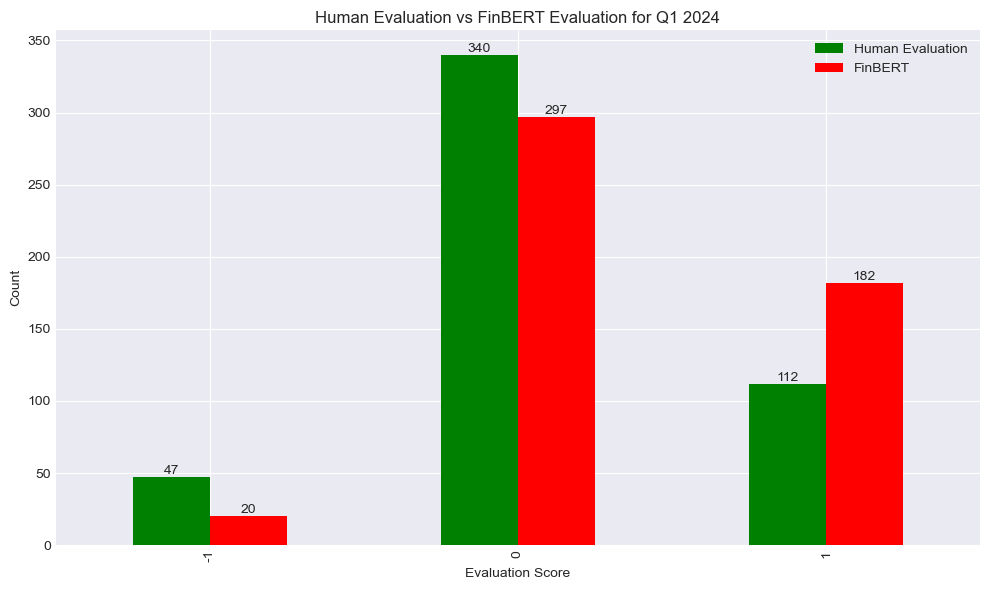

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\3021014979.py:47: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_human_vs_finbert(human_eval=pd.value_counts(d23['Human Evaluation']),
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\3021014979.py:48: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  fin_eval=pd.value_counts(d23['FinBERT']),


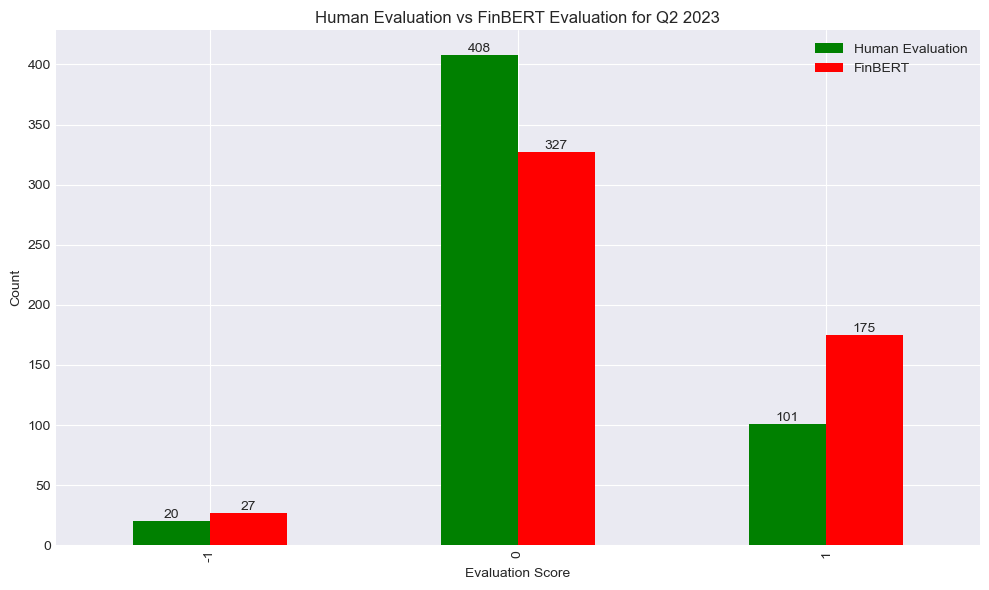

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\3021014979.py:52: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_human_vs_finbert(human_eval=pd.value_counts(d20['Human Evaluation']),
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\3021014979.py:53: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  fin_eval=pd.value_counts(d20['FinBERT']),


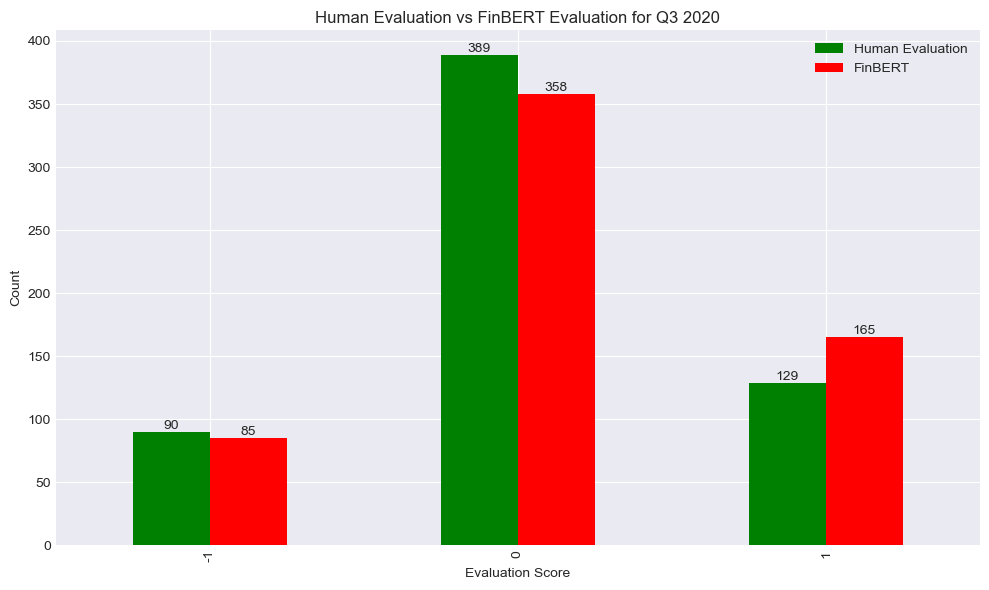

In [143]:
def plot_human_vs_finbert(human_eval, fin_eval, title_suffix):
    """
    Plots the comparison between human evaluation and FinBERT evaluation.
    
    Parameters:
    - human_eval: Series containing human evaluation counts.
    - fin_eval: Series containing FinBERT evaluation counts.
    - title_suffix: Suffix to append to the plot title for specifying the quarter.
    """
    # Convert the value counts to DataFrames to align the indices
    human_eval_df = human_eval.sort_index().reset_index()
    human_eval_df.columns = ['Score', 'Human Evaluation']

    finbert_eval_df = fin_eval.sort_index().reset_index()
    finbert_eval_df.columns = ['Score', 'FinBERT']

    # Merge the two DataFrames on 'Score'
    combined_df = pd.merge(human_eval_df, finbert_eval_df, on='Score', how='outer').fillna(0)

    # Set the 'Score' as the index for plotting
    combined_df.set_index('Score', inplace=True)

    # Plot the bar chart with new colors
    ax = combined_df.plot(kind='bar', figsize=(10, 6), color=['green', 'red'])

    # Add title and labels
    plt.title(f'Human Evaluation vs FinBERT Evaluation {title_suffix}')
    plt.xlabel('Evaluation Score')
    plt.ylabel('Count')

    # Add numbers on top of each bar
    for container in ax.containers:
        ax.bar_label(container, label_type='edge') 

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Display the plot
    plt.show()

# Human vs FinBERT for Q1 2024
plot_human_vs_finbert(human_eval=pd.value_counts(d24['Human Evaluation']), 
                      fin_eval=pd.value_counts(d24['FinBERT']), 
                      title_suffix='for Q1 2024')

# Human vs FinBERT for Q2 2023
plot_human_vs_finbert(human_eval=pd.value_counts(d23['Human Evaluation']), 
                      fin_eval=pd.value_counts(d23['FinBERT']), 
                      title_suffix='for Q2 2023')

# Human vs FinBERT for Q3 2020
plot_human_vs_finbert(human_eval=pd.value_counts(d20['Human Evaluation']), 
                      fin_eval=pd.value_counts(d20['FinBERT']), 
                      title_suffix='for Q3 2020')


## Combining Human Evaluation and GPT-3.5 Sentiment Analysis Excel Files for Comparative Analysis

In [144]:
# Function to load, clean, and combine evaluation files
def combine_evaluations(human_eval_file, gpt_output_file, final_output_file_path):
    # Load the Excel files
    human_eval_df = pd.read_excel(human_eval_file)
    gpt_output_df = pd.read_excel(gpt_output_file)
    
    # Drop the sentence column from the GPT output file
    gpt_output_df_cleaned = gpt_output_df.drop(columns=['Sentence'])
    
    # Concatenate the cleaned GPT output with the human evaluation file
    final_df = pd.concat([human_eval_df, gpt_output_df_cleaned], axis=1)
    
    # Save the final dataframe to a new Excel file
    final_df.to_excel(final_output_file_path, index=False)
    
    return final_output_file_path

# Define the quarters and corresponding file paths
quarters = {
    '1Q24': ('1Q24 Earnings Human Evaluation.xlsx', 'gpt_sentiment_analysis_1Q24.xlsx', 'combined_evaluation1Q24GPT3.xlsx'),
    '2Q23': ('2Q23 Earnings Human Evaluation.xlsx', 'gpt_sentiment_analysis_2Q23.xlsx', 'combined_evaluation2Q23GPT3.xlsx'),
    '3Q20': ('3Q20 Earnings Human Evaluation.xlsx', 'gpt_sentiment_analysis_3Q20.xlsx', 'combined_evaluation3Q20GPT3.xlsx')
}

# Process each quarter
for quarter, (human_eval_file, gpt_output_file, final_output_file_path) in quarters.items():
    output_file = combine_evaluations(human_eval_file, gpt_output_file, final_output_file_path)
    print(f"Processed and saved combined evaluations for {quarter} to {output_file}")



Processed and saved combined evaluations for 1Q24 to combined_evaluation1Q24GPT3.xlsx
Processed and saved combined evaluations for 2Q23 to combined_evaluation2Q23GPT3.xlsx
Processed and saved combined evaluations for 3Q20 to combined_evaluation3Q20GPT3.xlsx


In [145]:
# Load the final combined file for Q3 2020 to check the columns
df20 = pd.read_excel("combined_evaluation3Q20GPT3.xlsx")
df20.columns = df20.columns.str.strip()  # Remove any leading/trailing spaces in column names

# Check the column names
print(df20.columns)

Index(['Sentence', 'Human Evaluation', 'GPT 3.5'], dtype='object')


## Comparative Analysis of Human Evaluation and GPT-3.5 Sentiment Analysis Across All Quarters


Q1 2024

In [146]:
df24= pd.read_excel("combined_evaluation1Q24GPT3.xlsx")
#human_eval
human_eval=pd.value_counts(df24['Human Evaluation'])
# ChatGPT4_eval
chatGPT3_eval=pd.value_counts(df24['GPT 3.5'])

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1937306806.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval=pd.value_counts(df24['Human Evaluation'])
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1937306806.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  chatGPT3_eval=pd.value_counts(df24['GPT 3.5'])


Agreement Rate: 41.48%
Disagreement Rate: 58.52%
Human Mean: 0.13, GPT 3.5 Mean: 0.72
Human Std Dev: 0.55, GPT 3.5 Std Dev: 0.53
Correlation: 0.41
Accuracy: 0.41

Confusion Matrix:
[[ 14  16  17]
 [  6  83 251]
 [  0   2 110]]


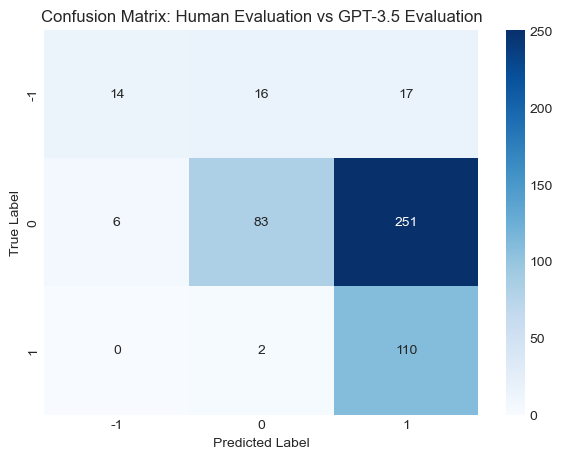

In [147]:
# Calculate agreement and disagreement rates
df24['Agreement'] = df24['Human Evaluation'] == df24['GPT 3.5']
agreement_rate = df24['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-3.5 evaluations
human_mean = df24['Human Evaluation'].mean()
chatgpt_mean = df24['GPT 3.5'].mean()

human_std = df24['Human Evaluation'].std()
chatgpt_std = df24['GPT 3.5'].std()

# Calculate the correlation between human and ChatGPT-3.5 evaluations
correlation = df24['Human Evaluation'].corr(df24['GPT 3.5'])

# Calculate accuracy
accuracy = accuracy_score(df24['Human Evaluation'], df24['GPT 3.5'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(df24['Human Evaluation'], df24['GPT 3.5'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, GPT 3.5 Mean: {chatgpt_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, GPT 3.5 Std Dev: {chatgpt_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Human Evaluation vs GPT-3.5 Evaluation')
plt.show()

Q2 2023

In [148]:
df23= pd.read_excel("combined_evaluation2Q23GPT3.xlsx")
#human_eval
human_eval=pd.value_counts(df23['Human Evaluation'])
# ChatGPT4_eval
chatGPT3_eval=pd.value_counts(df23['GPT 3.5'])

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\4213600509.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval=pd.value_counts(df23['Human Evaluation'])
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\4213600509.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  chatGPT3_eval=pd.value_counts(df23['GPT 3.5'])


Agreement Rate: 42.53%
Disagreement Rate: 57.47%
Human Mean: 0.15, GPT 3.5 Mean: 0.67
Human Std Dev: 0.45, GPT 3.5 Std Dev: 0.53
Correlation: 0.35
Accuracy: 0.43

Confusion Matrix:
[[  9   9   2]
 [  6 124 278]
 [  0   9  92]]


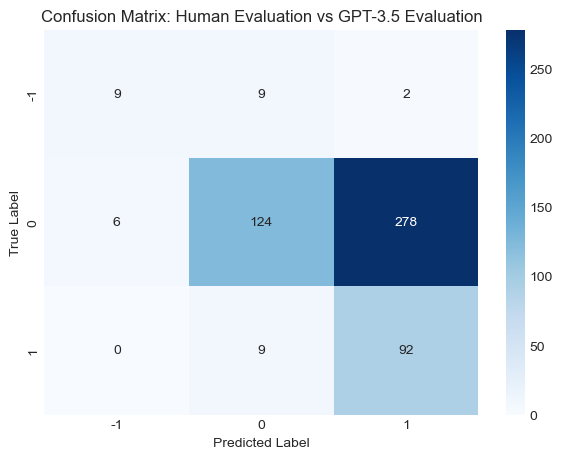

In [149]:
# Calculate agreement and disagreement rates
df23['Agreement'] = df23['Human Evaluation'] == df23['GPT 3.5']
agreement_rate = df23['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-3.5 evaluations
human_mean = df23['Human Evaluation'].mean()
chatgpt_mean = df23['GPT 3.5'].mean()

human_std = df23['Human Evaluation'].std()
chatgpt_std = df23['GPT 3.5'].std()

# Calculate the correlation between human and ChatGPT-3.5 evaluations
correlation = df23['Human Evaluation'].corr(df23['GPT 3.5'])

# Calculate accuracy
accuracy = accuracy_score(df23['Human Evaluation'], df23['GPT 3.5'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(df23['Human Evaluation'], df23['GPT 3.5'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, GPT 3.5 Mean: {chatgpt_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, GPT 3.5 Std Dev: {chatgpt_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Human Evaluation vs GPT-3.5 Evaluation')
plt.show()

Q3 2020

In [150]:
df20= pd.read_excel("combined_evaluation3Q20GPT3.xlsx")
# Strip spaces from column names
df20.columns = df20.columns.str.strip()

In [151]:
# Check the column names
print(df20.columns)

Index(['Sentence', 'Human Evaluation', 'GPT 3.5'], dtype='object')


In [152]:
#human_eval
human_eval=pd.value_counts(df20['Human Evaluation'])
# ChatGPT3_eval
chatGPT3_eval=pd.value_counts(df20['GPT 3.5'])

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1734166.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval=pd.value_counts(df20['Human Evaluation'])
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1734166.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  chatGPT3_eval=pd.value_counts(df20['GPT 3.5'])


Agreement Rate: 56.74%
Disagreement Rate: 43.26%
Human Mean: 0.06, GPT 3.5 Mean: 0.37
Human Std Dev: 0.60, GPT 3.5 Std Dev: 0.74
Correlation: 0.57
Accuracy: 0.57

Confusion Matrix:
[[ 59  21  10]
 [ 35 164 190]
 [  2   5 122]]


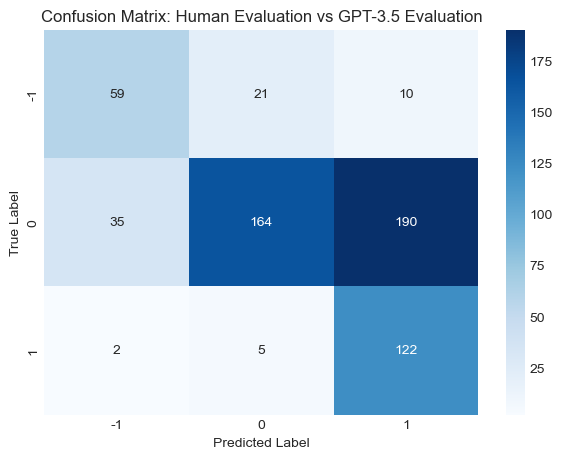

In [153]:
# Calculate agreement and disagreement rates
df20['Agreement'] = df20['Human Evaluation'] == df20['GPT 3.5']
agreement_rate = df20['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-3.5 evaluations
human_mean = df20['Human Evaluation'].mean()
chatgpt_mean = df20['GPT 3.5'].mean()

human_std = df20['Human Evaluation'].std()
chatgpt_std = df20['GPT 3.5'].std()

# Calculate the correlation between human and ChatGPT-3.5 evaluations
correlation = df20['Human Evaluation'].corr(df20['GPT 3.5'])

# Calculate accuracy
accuracy = accuracy_score(df20['Human Evaluation'], df20['GPT 3.5'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(df20['Human Evaluation'], df20['GPT 3.5'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, GPT 3.5 Mean: {chatgpt_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, GPT 3.5 Std Dev: {chatgpt_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Human Evaluation vs GPT-3.5 Evaluation')
plt.show()

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1453666084.py:45: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval_24 = pd.value_counts(df24['Human Evaluation'])
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1453666084.py:46: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  gpt3_eval_24 = pd.value_counts(df24['GPT 3.5'])


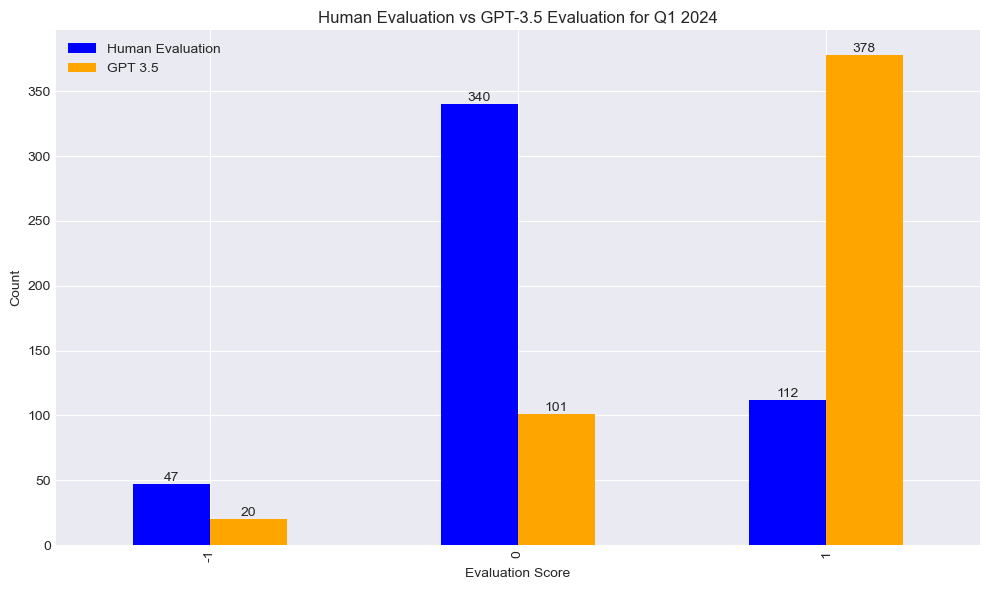

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1453666084.py:52: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval_23 = pd.value_counts(df23['Human Evaluation'])
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1453666084.py:53: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  gpt3_eval_23 = pd.value_counts(df23['GPT 3.5'])


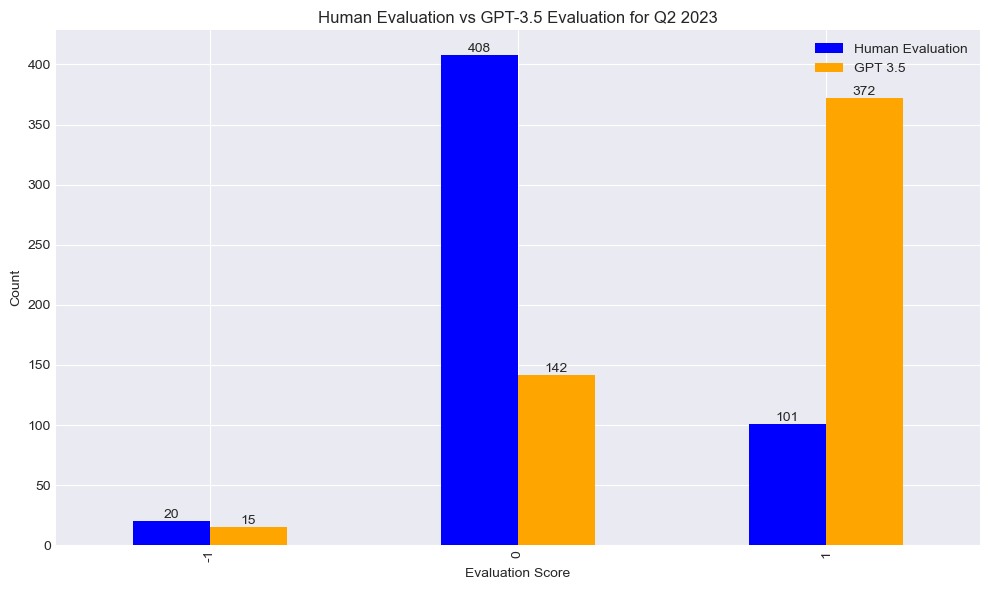

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1453666084.py:60: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval_20 = pd.value_counts(df20['Human Evaluation'])
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\1453666084.py:61: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  gpt3_eval_20 = pd.value_counts(df20['GPT 3.5'])


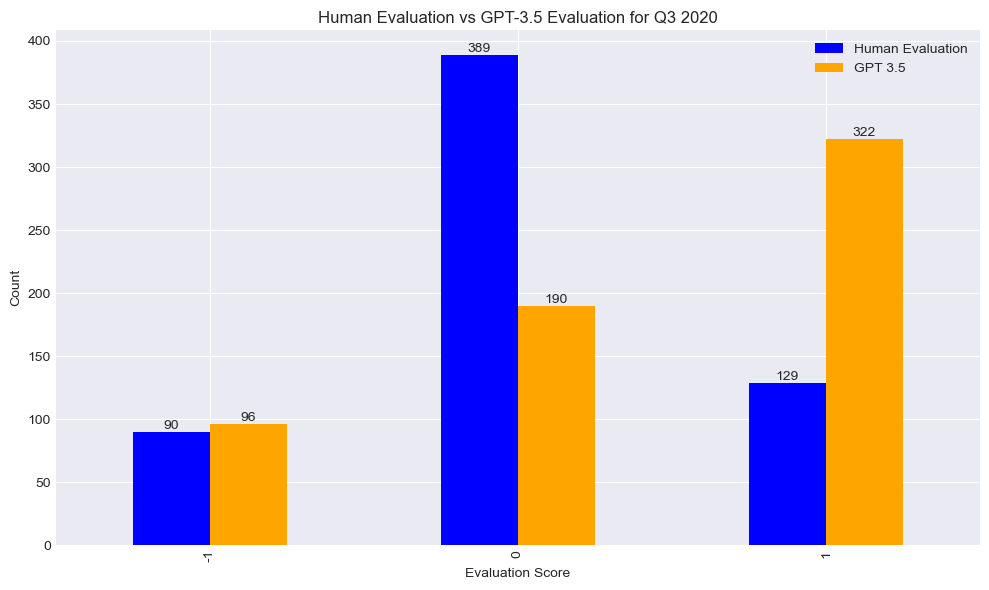

In [154]:
def plot_human_vs_gpt3(human_eval, gpt3_eval, title_suffix):
    """
    Plots the comparison between human evaluation and GPT-3.5 evaluation.
    
    Parameters:
    - human_eval: Series containing human evaluation counts.
    - gpt3_eval: Series containing GPT-3.5 evaluation counts.
    - title_suffix: Suffix to append to the plot title for specifying the quarter.
    """
    # Convert the value counts to DataFrames to align the indices
    human_eval_df = human_eval.sort_index().reset_index()
    human_eval_df.columns = ['Score', 'Human Evaluation']

    gpt3_eval_df = gpt3_eval.sort_index().reset_index()
    gpt3_eval_df.columns = ['Score', 'GPT 3.5']

    # Merge the two DataFrames on 'Score'
    combined_df = pd.merge(human_eval_df, gpt3_eval_df, on='Score', how='outer').fillna(0)

    # Set the 'Score' as the index for plotting
    combined_df.set_index('Score', inplace=True)

    # Plot the bar chart
    ax = combined_df.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])

    # Add title and labels
    plt.title(f'Human Evaluation vs GPT-3.5 Evaluation {title_suffix}')
    plt.xlabel('Evaluation Score')
    plt.ylabel('Count')

    # Add numbers on top of each bar
    for container in ax.containers:
        ax.bar_label(container, label_type='edge') 

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Display the plot
    plt.show()

# Read data and plot for each quarter

# Q1 2024
df24 = pd.read_excel("combined_evaluation1Q24GPT3.xlsx")
human_eval_24 = pd.value_counts(df24['Human Evaluation'])
gpt3_eval_24 = pd.value_counts(df24['GPT 3.5'])

plot_human_vs_gpt3(human_eval=human_eval_24, gpt3_eval=gpt3_eval_24, title_suffix='for Q1 2024')

# Q2 2023
df23 = pd.read_excel("combined_evaluation2Q23GPT3.xlsx")
human_eval_23 = pd.value_counts(df23['Human Evaluation'])
gpt3_eval_23 = pd.value_counts(df23['GPT 3.5'])

plot_human_vs_gpt3(human_eval=human_eval_23, gpt3_eval=gpt3_eval_23, title_suffix='for Q2 2023')

# Q3 2020
df20 = pd.read_excel("combined_evaluation3Q20GPT3.xlsx")
df20.columns = df20.columns.str.strip()  # Strip spaces from column names
human_eval_20 = pd.value_counts(df20['Human Evaluation'])
gpt3_eval_20 = pd.value_counts(df20['GPT 3.5'])

plot_human_vs_gpt3(human_eval=human_eval_20, gpt3_eval=gpt3_eval_20, title_suffix='for Q3 2020')

# ChatGPT4 

Prompt used: "as a trader in the bank with 20 years of experience in the stock market I want you to read the parsed earning call and score each sentence (negative: -1, natural: 0 and positive: 1). How is each sentence important to make your decision after the earning call and to make you decision to either buy, sell or hold"

## Comparative Analysis of Human Evaluation and GPT-4 Sentiment Analysis Across All Quarters


1Q24

In [155]:
dff24= pd.read_excel("1Q24 Earnings Evaluation.xlsx")
dff24.head(10)

,Sentence,Human Evaluation,ChatGPT4 Evaluation
0,ExxonMobil First Quarter 2024 Earnings Call T...,0,0
1,Today ’s call is being recorded.,0,0
2,I ’ll now turn it over to Ms. Marina Matselins...,0,0
3,Please go ahead .,0,0
4,"Marina Matselinskaya : Good morning, everyone.",0,0
5,Welcome to ExxonMobil’s first -quarter 2024 ea...,0,0
6,We appreciate you joining the call today.,0,0
7,"I’m Marina Matselinskaya, Director of Investor...",0,0
8,"I’m joined by Darren Woods, Chairman and CEO, ...",0,0
9,This presentation and prerecorded remarks are ...,0,0


In [156]:
# Calculate agreement and disagreement rates
dff24['Agreement'] = dff24['Human Evaluation'] == dff24['ChatGPT4 Evaluation']
agreement_rate = dff24['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-3.5 evaluations
human_mean = dff24['Human Evaluation'].mean()
chatgpt_mean = dff24['ChatGPT4 Evaluation'].mean()

human_std = dff24['Human Evaluation'].std()
chatgpt_std = dff24['ChatGPT4 Evaluation'].std()

# Calculate the correlation between human and ChatGPT-3.5 evaluations
correlation = dff24['Human Evaluation'].corr(dff24['ChatGPT4 Evaluation'])

# Calculate accuracy
accuracy = accuracy_score(dff24['Human Evaluation'], dff24['ChatGPT4 Evaluation'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(dff24['Human Evaluation'], dff24['ChatGPT4 Evaluation'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, GPT 4 Mean: {chatgpt_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, GPT 4 Std Dev: {chatgpt_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Agreement Rate: 66.93%
Disagreement Rate: 33.07%
Human Mean: 0.13, GPT 4 Mean: 0.04
Human Std Dev: 0.55, GPT 4 Std Dev: 0.30
Correlation: 0.14
Accuracy: 0.67

Confusion Matrix:
[[  6  38   3]
 [  6 316  18]
 [  1  99  12]]


2Q23

In [157]:
dff23= pd.read_excel("2Q23 Earnings Evaluation.xlsx")
dff23.head(10)

,Sentence,Human Evaluation,ChatGPT4 Evaluation
0,ExxonMobil Second Quarter 2023 Earnings Call ...,0,0
1,"Operator: Good day everyone, and welcome to th...",0,0
2,Today's call is being recorded.,0,0
3,"At this time, I'd like to turn the call over t...",0,0
4,Jennifer Driscoll.,0,0
5,"Please go ahead, ma’am.",0,0
6,"Jennifer Driscoll: Good morning, everyone.",0,0
7,Welcome to ExxonMobil’s second -quarte r 2023 ...,0,0
8,"I’m Jennifer Driscoll, Vice President - Invest...",0,0
9,"I’m joined by Darren Woods, Chairman and CEO, ...",0,0


In [158]:
# Calculate agreement and disagreement rates
dff23['Agreement'] = dff23['Human Evaluation'] == dff23['ChatGPT4 Evaluation']
agreement_rate = dff23['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-4 evaluations
human_mean = dff23['Human Evaluation'].mean()
chatgpt_mean = dff23['ChatGPT4 Evaluation'].mean()

human_std = dff23['Human Evaluation'].std()
chatgpt_std = dff23['ChatGPT4 Evaluation'].std()

# Calculate the correlation between human and ChatGPT-4 evaluations
correlation = dff23['Human Evaluation'].corr(dff23['ChatGPT4 Evaluation'])

# Calculate accuracy
accuracy = accuracy_score(dff23['Human Evaluation'], dff23['ChatGPT4 Evaluation'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(dff23['Human Evaluation'], dff23['ChatGPT4 Evaluation'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, GPT 4 Mean: {chatgpt_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, GPT 4 Std Dev: {chatgpt_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Agreement Rate: 75.99%
Disagreement Rate: 24.01%
Human Mean: 0.15, GPT 4 Mean: 0.06
Human Std Dev: 0.45, GPT 4 Std Dev: 0.31
Correlation: 0.16
Accuracy: 0.76

Confusion Matrix:
[[  3  16   1]
 [  4 381  23]
 [  3  80  18]]


 3Q20

In [159]:
dff20= pd.read_excel("3Q20_Earnings Evaluation.xlsx")
dff20.head(10)

,Sentence,Human Evaluation,ChatGPT4 Evaluation
0,Exxon Mobil Corporation (NYSE:XOM) Q3 2020 Ear...,0,0
1,Today's call is being recorded.,0,0
2,"At this time, I'd like to turn the call over t...",0,0
3,"Please go ahead, sir.",0,0
4,Stephen Littleton: Thank you.,0,0
5,"Good morning, everyone.",0,0
6,Welcome to our third quarter earnings call.,0,0
7,We appreciate your participation and continued...,0,0
8,"I am Stephen Littleton, Vice President of Inve...",0,0
9,"Before getting started, I wanted to say that I...",0,-1


In [160]:
# Calculate agreement and disagreement rates
dff20['Agreement'] = dff20['Human Evaluation'] == dff20['ChatGPT4 Evaluation']
agreement_rate = dff20['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-4 evaluations
human_mean = dff20['Human Evaluation'].mean()
chatgpt_mean = dff20['ChatGPT4 Evaluation'].mean()

human_std = dff20['Human Evaluation'].std()
chatgpt_std = dff20['ChatGPT4 Evaluation'].std()

# Calculate the correlation between human and ChatGPT-4 evaluations
correlation = dff20['Human Evaluation'].corr(dff20['ChatGPT4 Evaluation'])

# Calculate accuracy
accuracy = accuracy_score(dff20['Human Evaluation'], dff20['ChatGPT4 Evaluation'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(dff20['Human Evaluation'], dff20['ChatGPT4 Evaluation'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, GPT 4 Mean: {chatgpt_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, GPT 4 Std Dev: {chatgpt_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Agreement Rate: 65.95%
Disagreement Rate: 34.05%
Human Mean: 0.06, GPT 4 Mean: 0.05
Human Std Dev: 0.60, GPT 4 Std Dev: 0.35
Correlation: 0.23
Accuracy: 0.66

Confusion Matrix:
[[ 13  71   6]
 [  8 362  19]
 [  2 101  26]]


C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\896503958.py:48: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval_24 = pd.value_counts(dff24['Human Evaluation']).sort_index()
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\896503958.py:49: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  chatgpt4_eval_24 = pd.value_counts(dff24['ChatGPT4 Evaluation']).sort_index()


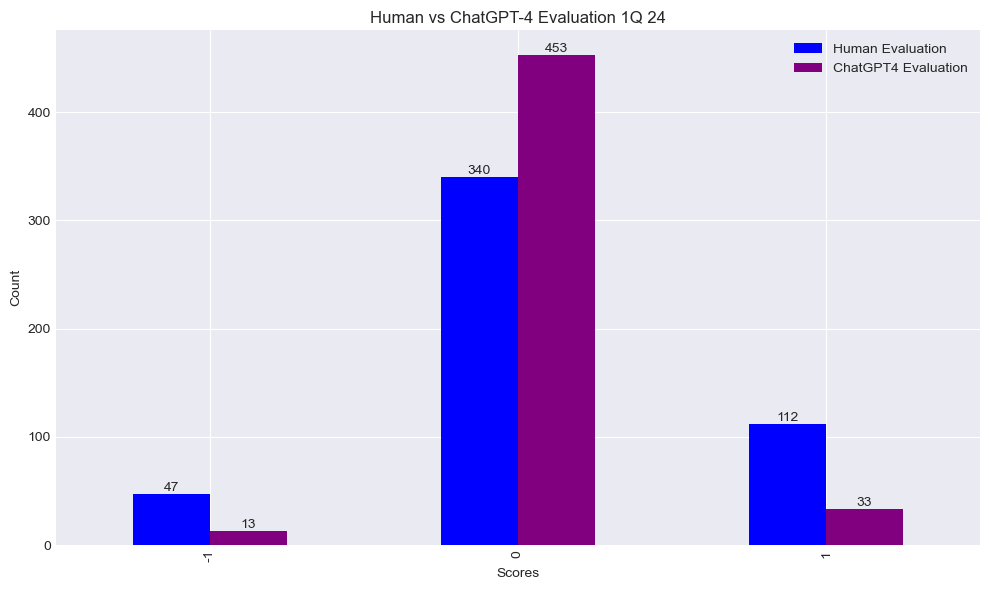

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\896503958.py:55: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval_23 = pd.value_counts(dff23['Human Evaluation']).sort_index()
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\896503958.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  chatgpt4_eval_23 = pd.value_counts(dff23['ChatGPT4 Evaluation']).sort_index()


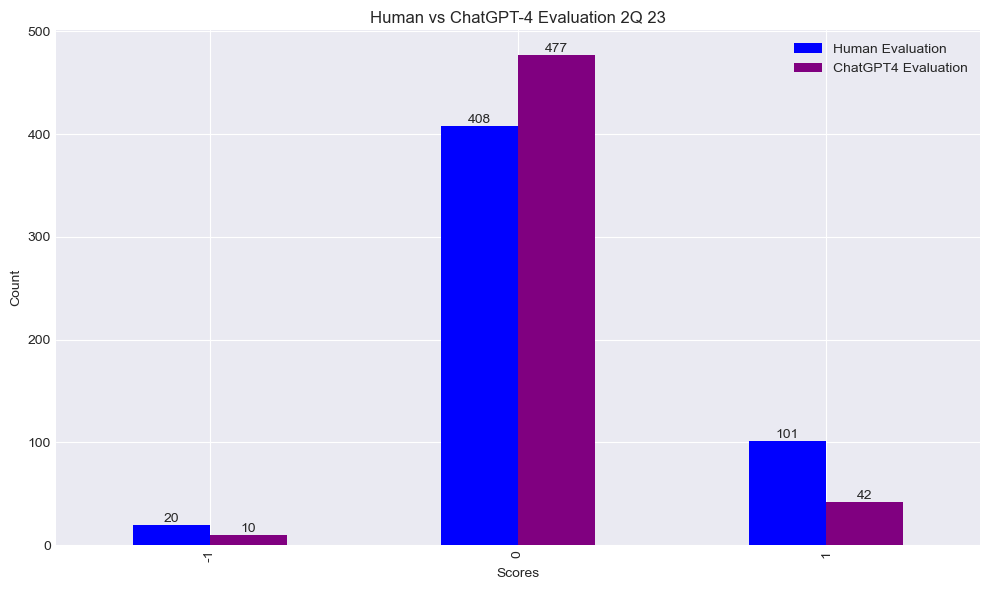

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\896503958.py:62: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval_20 = pd.value_counts(dff20['Human Evaluation']).sort_index()
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\896503958.py:63: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  chatgpt4_eval_20 = pd.value_counts(dff20['ChatGPT4 Evaluation']).sort_index()


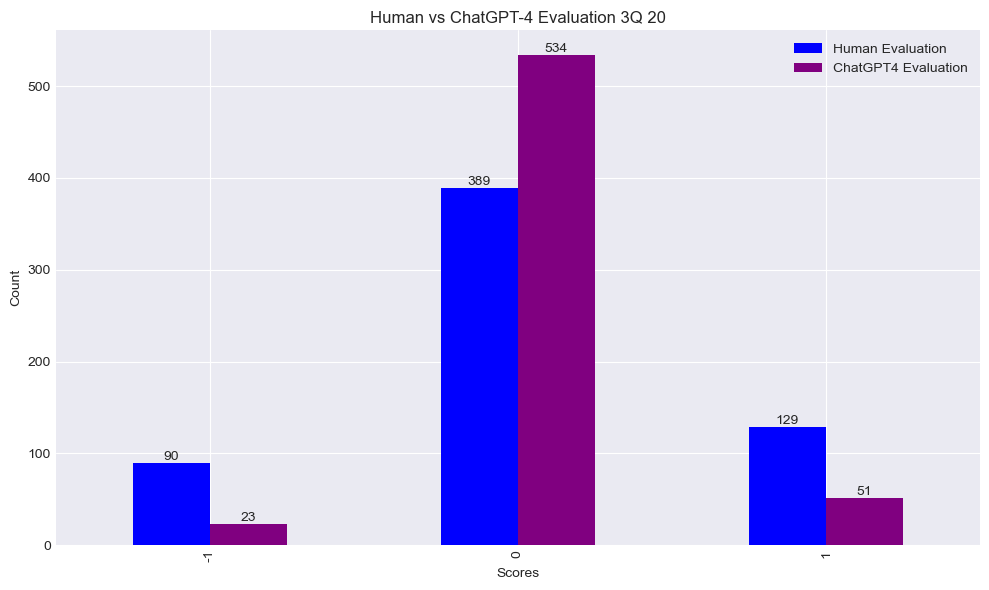

In [161]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_human_vs_chatgpt4(human_eval, chatgpt4_eval, title_suffix):
    """
    Plots the comparison between human evaluation and ChatGPT-4 evaluation.
    
    Parameters:
    - human_eval: Series containing human evaluation counts.
    - chatgpt4_eval: Series containing ChatGPT-4 evaluation counts.
    - title_suffix: Suffix to append to the plot title for specifying the quarter.
    """
    # Convert the value counts to DataFrames to align the indices
    human_eval_df = human_eval.sort_index().reset_index()
    human_eval_df.columns = ['Score', 'Human Evaluation']

    chatgpt4_eval_df = chatgpt4_eval.sort_index().reset_index()
    chatgpt4_eval_df.columns = ['Score', 'ChatGPT4 Evaluation']

    # Merge the two DataFrames on 'Score'
    combined_df = pd.merge(human_eval_df, chatgpt4_eval_df, on='Score', how='outer').fillna(0)

    # Set the 'Score' as the index for plotting
    combined_df.set_index('Score', inplace=True)

    # Plot the bar chart with specified colors
    ax = combined_df.plot(kind='bar', figsize=(10, 6), color=['blue', 'purple'])

    # Add title and labels
    plt.title(f'Human vs ChatGPT-4 Evaluation {title_suffix}')
    plt.xlabel('Scores')
    plt.ylabel('Count')

    # Add numbers on top of each bar
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Display the plot
    plt.show()

# Read data and plot for each quarter

# Q1 2024
dff24 = pd.read_excel("1Q24 Earnings Evaluation.xlsx")
human_eval_24 = pd.value_counts(dff24['Human Evaluation']).sort_index()
chatgpt4_eval_24 = pd.value_counts(dff24['ChatGPT4 Evaluation']).sort_index()

plot_human_vs_chatgpt4(human_eval=human_eval_24, chatgpt4_eval=chatgpt4_eval_24, title_suffix='1Q 24')

# Q2 2023
dff23 = pd.read_excel("2Q23 Earnings Evaluation.xlsx")
human_eval_23 = pd.value_counts(dff23['Human Evaluation']).sort_index()
chatgpt4_eval_23 = pd.value_counts(dff23['ChatGPT4 Evaluation']).sort_index()

plot_human_vs_chatgpt4(human_eval=human_eval_23, chatgpt4_eval=chatgpt4_eval_23, title_suffix='2Q 23')

# Q3 2020
dff20 = pd.read_excel("3Q20_Earnings Evaluation.xlsx")
human_eval_20 = pd.value_counts(dff20['Human Evaluation']).sort_index()
chatgpt4_eval_20 = pd.value_counts(dff20['ChatGPT4 Evaluation']).sort_index()

plot_human_vs_chatgpt4(human_eval=human_eval_20, chatgpt4_eval=chatgpt4_eval_20, title_suffix='3Q 20')


# Gemini 

Prompt used: " you are a finance expert with 40 years of experience. I want you to grade each sentence of this earning transcript and give a sentiment score of either 1, 0 or -1 representing (positive sentiment, neutral and negative sentiment for investor). Your analysis should be based on the perspective of a senior stock trader who is analyzing Exxon earning call transcript. Please provide me with your answer in a excel file" 

## Comparative Analysis of Human Evaluation and Gemini Sentiment Analysis Across All Quarters

1Q24

In [162]:
dfq24= pd.read_excel("1Q24 Earnings Gemini.xlsx")
dfq24.head(10)

,Sentence,Gemini Evaluation,Human Evaluation
0,Excerpt from ExxonMobil 1Q24 Earnings Call 1 ...,0,0
1,Today ’s call is being recorded.,1,0
2,I ’ll now turn it over to Ms. Marina Matselins...,0,0
3,Please go ahead .,0,0
4,"Marina Matselinskaya : Good morning, everyone.",0,0
5,Welcome to ExxonMobil’s first -quarter 2024 ea...,0,0
6,We appreciate you joining the call today.,0,0
7,"I’m Marina Matselinskaya, Director of Investor...",0,0
8,"I’m joined by Darren Woods, Chairman and CEO, ...",0,0
9,This presentation and prerecorded remarks are ...,1,0


In [163]:
dfq24.columns = dfq24.columns.str.strip()

In [164]:
# Calculate agreement and disagreement rates
dfq24['Agreement'] = dfq24['Human Evaluation'] == dfq24['Gemini Evaluation']
agreement_rate = dfq24['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-3.5 evaluations
human_mean = dfq24['Human Evaluation'].mean()
gemini_mean = dfq24['Gemini Evaluation'].mean()

human_std = dfq24['Human Evaluation'].std()
gemini_std = dfq24['Gemini Evaluation'].std()

# Calculate the correlation between human and ChatGPT-3.5 evaluations
correlation = dfq24['Human Evaluation'].corr(dfq24['Gemini Evaluation'])

# Calculate accuracy
accuracy = accuracy_score(dfq24['Human Evaluation'], dfq24['Gemini Evaluation'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(dfq24['Human Evaluation'], dfq24['Gemini Evaluation'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, Gemini Mean: {gemini_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, Gemini Std Dev: {gemini_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Agreement Rate: 66.93%
Disagreement Rate: 33.07%
Human Mean: 0.13, Gemini Mean: 0.11
Human Std Dev: 0.55, Gemini Std Dev: 0.36
Correlation: 0.20
Accuracy: 0.67

Confusion Matrix:
[[  2  42   3]
 [  5 304  31]
 [  0  84  28]]


2Q23

In [165]:
dfq23= pd.read_excel("2Q23 Earnings Gemini.xlsx")
dfq23.head(10)

,Sentence,Gemini Evaluation,Human Evaluation
0,ExxonMobil Second Quarter 2023 Earnings Call ...,0,0
1,"Operator: Good day everyone, and welcome to th...",0,0
2,Today's call is being recorded.,1,0
3,"At this time, I'd like to turn the call over t...",0,0
4,Jennifer Driscoll.,0,0
5,"Please go ahead, ma’am.",0,0
6,"Jennifer Driscoll: Good morning, everyone.",0,0
7,Welcome to ExxonMobil’s second -quarte r 2023 ...,0,0
8,"I’m Jennifer Driscoll, Vice President - Invest...",0,0
9,"I’m joined by Darren Woods, Chairman and CEO, ...",0,0


In [166]:
# Calculate agreement and disagreement rates
dfq23['Agreement'] = dfq23['Human Evaluation'] == dfq23['Gemini Evaluation']
agreement_rate = dfq23['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-3.5 evaluations
human_mean = dfq23['Human Evaluation'].mean()
gemini_mean = dfq23['Gemini Evaluation'].mean()

human_std = dfq23['Human Evaluation'].std()
gemini_std = dfq23['Gemini Evaluation'].std()

# Calculate the correlation between human and ChatGPT-3.5 evaluations
correlation = dfq23['Human Evaluation'].corr(dfq23['Gemini Evaluation'])

# Calculate accuracy
accuracy = accuracy_score(dfq23['Human Evaluation'], dfq23['Gemini Evaluation'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(dfq23['Human Evaluation'], dfq23['Gemini Evaluation'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, Gemini Mean: {gemini_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, Gemini Std Dev: {gemini_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Agreement Rate: 74.86%
Disagreement Rate: 25.14%
Human Mean: 0.15, Gemini Mean: 0.11
Human Std Dev: 0.45, Gemini Std Dev: 0.33
Correlation: 0.17
Accuracy: 0.75

Confusion Matrix:
[[  0  18   2]
 [  3 371  34]
 [  1  75  25]]


 3Q20

In [167]:
dfq20= pd.read_excel("3Q20 Earnings Gemini.xlsx")
dfq20.head(10)

,Sentence,Gemini Evaluation,Human Evaluation
0,Exxon Mobil Corporation (NYSE:XOM) Q3 2020 Ear...,0,0
1,Today's call is being recorded.,1,0
2,"At this time, I'd like to turn the call over t...",0,0
3,"Please go ahead, sir.",0,0
4,Stephen Littleton: Thank you.,0,0
5,"Good morning, everyone.",0,0
6,Welcome to our third quarter earnings call.,0,0
7,We appreciate your participation and continued...,0,0
8,"I am Stephen Littleton, Vice President of Inve...",0,0
9,"Before getting started, I wanted to say that I...",-1,0


In [168]:
# Calculate agreement and disagreement rates
dfq20['Agreement'] = dfq20['Human Evaluation'] == dfq20['Gemini Evaluation']
agreement_rate = dfq20['Agreement'].mean() * 100
disagreement_rate = 100 - agreement_rate

# Calculate mean and standard deviation for both human and ChatGPT-3.5 evaluations
human_mean = dfq20['Human Evaluation'].mean()
gemini_mean = dfq20['Gemini Evaluation'].mean()

human_std = dfq20['Human Evaluation'].std()
gemini_std = dfq20['Gemini Evaluation'].std()

# Calculate the correlation between human and ChatGPT-3.5 evaluations
correlation = dfq20['Human Evaluation'].corr(dfq20['Gemini Evaluation'])

# Calculate accuracy
accuracy = accuracy_score(dfq20['Human Evaluation'], dfq20['Gemini Evaluation'])

# Generate a confusion matrix
conf_matrix = confusion_matrix(dfq20['Human Evaluation'], dfq20['Gemini Evaluation'])

# Output the results
print(f"Agreement Rate: {agreement_rate:.2f}%")
print(f"Disagreement Rate: {disagreement_rate:.2f}%")
print(f"Human Mean: {human_mean:.2f}, Gemini Mean: {gemini_mean:.2f}")
print(f"Human Std Dev: {human_std:.2f}, Gemini Std Dev: {gemini_std:.2f}")
print(f"Correlation: {correlation:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Agreement Rate: 64.47%
Disagreement Rate: 35.53%
Human Mean: 0.06, Gemini Mean: 0.09
Human Std Dev: 0.60, Gemini Std Dev: 0.35
Correlation: 0.17
Accuracy: 0.64

Confusion Matrix:
[[  6  76   8]
 [  3 356  30]
 [  3  96  30]]


C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\819064146.py:46: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval_24 = pd.value_counts(dfq24['Human Evaluation']).sort_index()
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\819064146.py:47: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  gemini_eval_24 = pd.value_counts(dfq24['Gemini Evaluation']).sort_index()


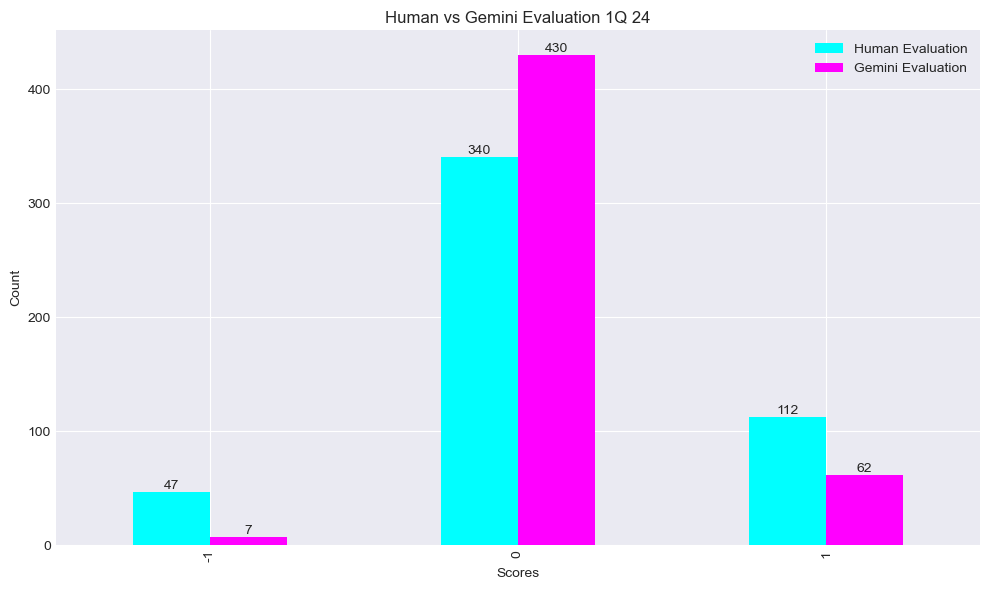

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\819064146.py:53: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval_23 = pd.value_counts(dfq23['Human Evaluation']).sort_index()
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\819064146.py:54: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  gemini_eval_23 = pd.value_counts(dfq23['Gemini Evaluation']).sort_index()


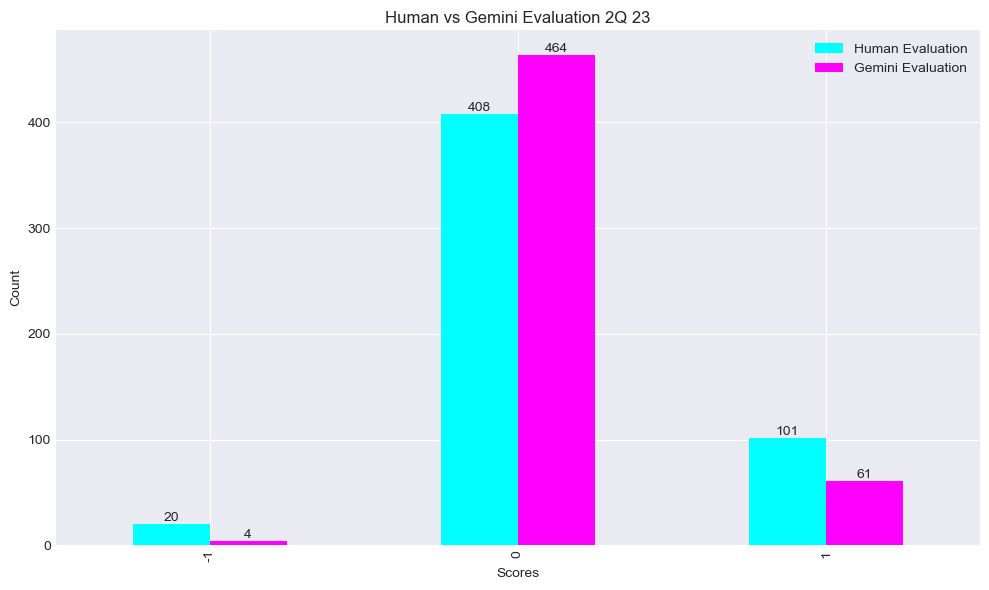

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\819064146.py:60: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  human_eval_20 = pd.value_counts(dfq20['Human Evaluation']).sort_index()
C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\819064146.py:61: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  gemini_eval_20 = pd.value_counts(dfq20['Gemini Evaluation']).sort_index()


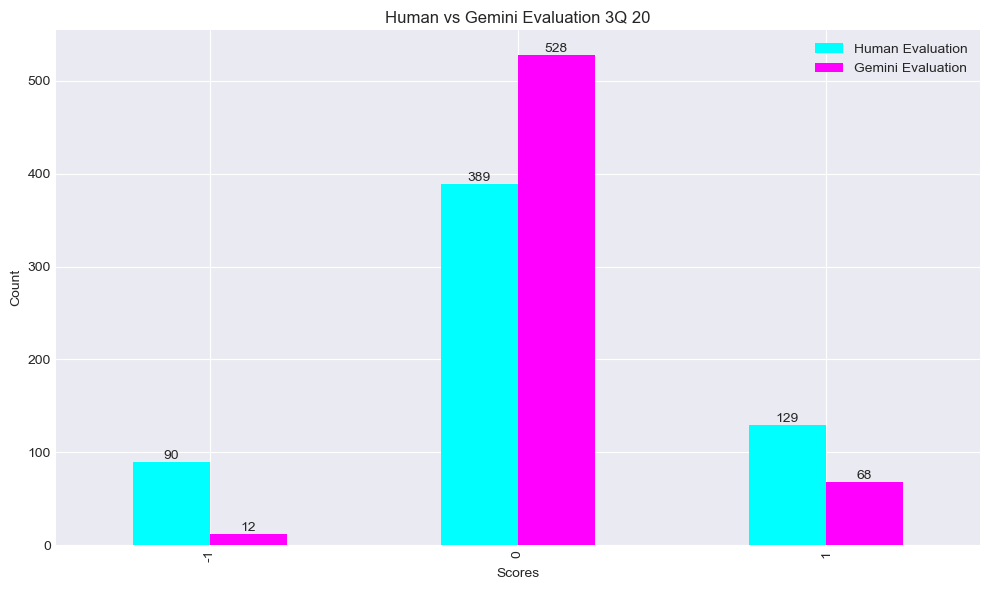

In [169]:
def plot_human_vs_gemini(human_eval, gemini_eval, title_suffix):
    """
    Plots the comparison between human evaluation and Gemini evaluation.
    
    Parameters:
    - human_eval: Series containing human evaluation counts.
    - gemini_eval: Series containing Gemini evaluation counts.
    - title_suffix: Suffix to append to the plot title for specifying the quarter.
    """
    # Convert the value counts to DataFrames to align the indices
    human_eval_df = human_eval.sort_index().reset_index()
    human_eval_df.columns = ['Score', 'Human Evaluation']

    gemini_eval_df = gemini_eval.sort_index().reset_index()
    gemini_eval_df.columns = ['Score', 'Gemini Evaluation']

    # Merge the two DataFrames on 'Score'
    combined_df = pd.merge(human_eval_df, gemini_eval_df, on='Score', how='outer').fillna(0)

    # Set the 'Score' as the index for plotting
    combined_df.set_index('Score', inplace=True)

    # Plot the bar chart with new colors
    ax = combined_df.plot(kind='bar', figsize=(10, 6), color=['cyan', 'magenta'])

    # Add title and labels
    plt.title(f'Human vs Gemini Evaluation {title_suffix}')
    plt.xlabel('Scores')
    plt.ylabel('Count')

    # Add numbers on top of each bar
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Display the plot
    plt.show()

# Read data and plot for each quarter

# Q1 2024
dfq24 = pd.read_excel("1Q24 Earnings Gemini.xlsx")
dfq24.columns = dfq24.columns.str.strip()  # Strip spaces from column names
human_eval_24 = pd.value_counts(dfq24['Human Evaluation']).sort_index()
gemini_eval_24 = pd.value_counts(dfq24['Gemini Evaluation']).sort_index()

plot_human_vs_gemini(human_eval=human_eval_24, gemini_eval=gemini_eval_24, title_suffix='1Q 24')

# Q2 2023
dfq23 = pd.read_excel("2Q23 Earnings Gemini.xlsx")
human_eval_23 = pd.value_counts(dfq23['Human Evaluation']).sort_index()
gemini_eval_23 = pd.value_counts(dfq23['Gemini Evaluation']).sort_index()

plot_human_vs_gemini(human_eval=human_eval_23, gemini_eval=gemini_eval_23, title_suffix='2Q 23')

# Q3 2020
dfq20 = pd.read_excel("3Q20 Earnings Gemini.xlsx")
human_eval_20 = pd.value_counts(dfq20['Human Evaluation']).sort_index()
gemini_eval_20 = pd.value_counts(dfq20['Gemini Evaluation']).sort_index()

plot_human_vs_gemini(human_eval=human_eval_20, gemini_eval=gemini_eval_20, title_suffix='3Q 20')

## Overall Evaluation of all LLMs against Human across all quarters

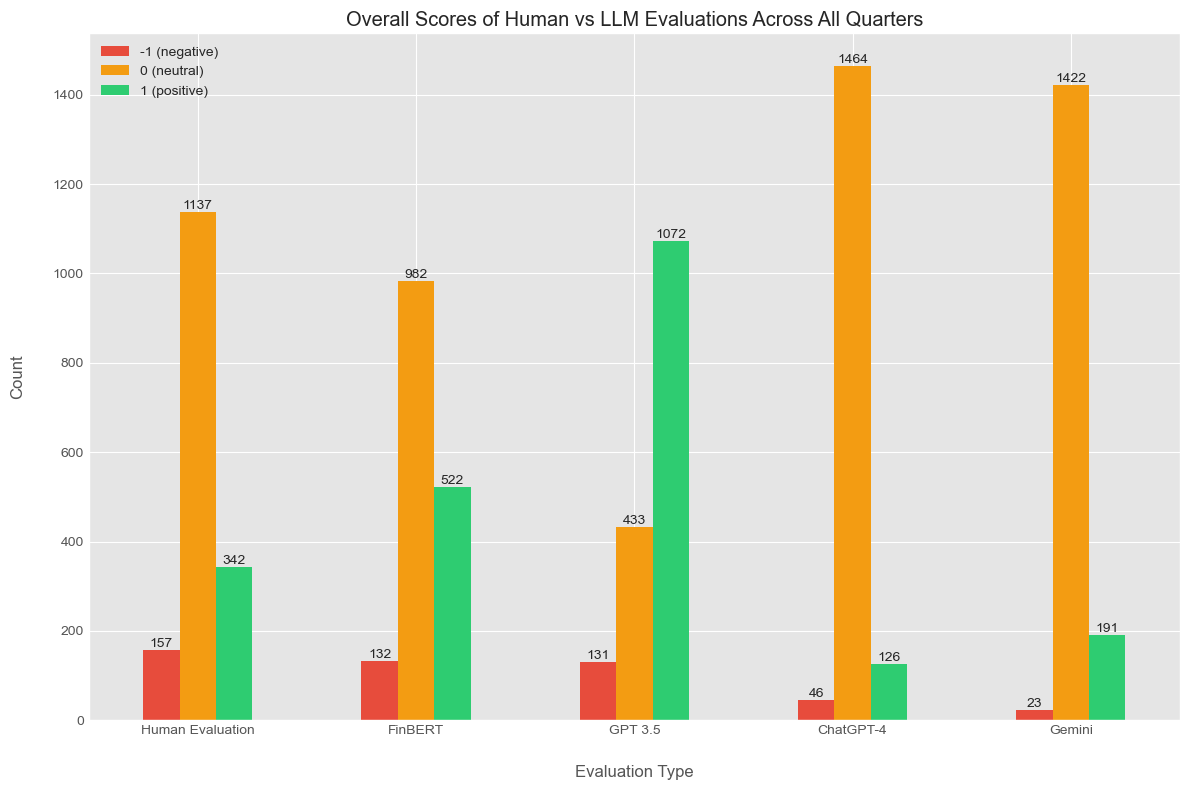

In [212]:
# Initialize overall count dictionaries for each evaluation
overall_counts = {
    'Human Evaluation': { -1: 0, 0: 0, 1: 0 },
    'FinBERT': { -1: 0, 0: 0, 1: 0 },
    'GPT 3.5': { -1: 0, 0: 0, 1: 0 },
    'ChatGPT-4': { -1: 0, 0: 0, 1: 0 },
    'Gemini': { -1: 0, 0: 0, 1: 0 }
}

# Helper function to update counts for a given evaluation
def update_counts(counts, eval_series, label):
    eval_counts = eval_series.value_counts().to_dict()
    for score in [-1, 0, 1]:
        counts[label][score] += eval_counts.get(score, 0)

# Helper function to clean column names and check for existence
def check_and_clean_column(df, column_name):
    df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace from column names
    if column_name in df.columns:
        return df[column_name]
    else:
        print(f"Column '{column_name}' not found in DataFrame.")
        return pd.Series([])  # Return an empty series if column not found

# Q1 2024
d24 = pd.read_excel("combined_evaluation1Q24Fin.xlsx")  # FinBERT evaluations
dff24 = pd.read_excel("1Q24 Earnings Evaluation.xlsx")  # ChatGPT-4 Evaluation
df24 = pd.read_excel("combined_evaluation1Q24GPT3.xlsx")  # GPT 3.5 Evaluation
dfq24 = pd.read_excel("1Q24 Earnings Gemini.xlsx")  # Gemini Evaluation

update_counts(overall_counts, check_and_clean_column(d24, 'Human Evaluation'), 'Human Evaluation')
update_counts(overall_counts, check_and_clean_column(d24, 'FinBERT'), 'FinBERT')
update_counts(overall_counts, check_and_clean_column(df24, 'GPT 3.5'), 'GPT 3.5')
update_counts(overall_counts, check_and_clean_column(dff24, 'ChatGPT4 Evaluation'), 'ChatGPT-4')
update_counts(overall_counts, check_and_clean_column(dfq24, 'Gemini Evaluation'), 'Gemini')

# Q2 2023
d23 = pd.read_excel("combined_evaluation2Q23Fin.xlsx")  # FinBERT evaluations
dff23 = pd.read_excel("2Q23 Earnings Evaluation.xlsx")  # ChatGPT-4 Evaluation
df23 = pd.read_excel("combined_evaluation2Q23GPT3.xlsx")  # GPT 3.5 Evaluation
dfq23 = pd.read_excel("2Q23 Earnings Gemini.xlsx")  # Gemini Evaluation

update_counts(overall_counts, check_and_clean_column(d23, 'Human Evaluation'), 'Human Evaluation')
update_counts(overall_counts, check_and_clean_column(d23, 'FinBERT'), 'FinBERT')
update_counts(overall_counts, check_and_clean_column(df23, 'GPT 3.5'), 'GPT 3.5')
update_counts(overall_counts, check_and_clean_column(dff23, 'ChatGPT4 Evaluation'), 'ChatGPT-4')
update_counts(overall_counts, check_and_clean_column(dfq23, 'Gemini Evaluation'), 'Gemini')

# Q3 2020
d20 = pd.read_excel("combined_evaluation3Q20Fin.xlsx")  # FinBERT evaluations
dff20 = pd.read_excel("3Q20_Earnings Evaluation.xlsx")  # ChatGPT-4 Evaluation
df20 = pd.read_excel("combined_evaluation3Q20GPT3.xlsx")  # GPT 3.5 Evaluation
dfq20 = pd.read_excel("3Q20 Earnings Gemini.xlsx")  # Gemini Evaluation

update_counts(overall_counts, check_and_clean_column(d20, 'Human Evaluation'), 'Human Evaluation')
update_counts(overall_counts, check_and_clean_column(d20, 'FinBERT'), 'FinBERT')
update_counts(overall_counts, check_and_clean_column(df20, 'GPT 3.5'), 'GPT 3.5')
update_counts(overall_counts, check_and_clean_column(dff20, 'ChatGPT4 Evaluation'), 'ChatGPT-4')
update_counts(overall_counts, check_and_clean_column(dfq20, 'Gemini Evaluation'), 'Gemini')

# Convert overall_counts to a DataFrame for plotting
overall_df = pd.DataFrame(overall_counts).T
overall_df.index.name = 'Evaluation'
overall_df.columns = ['-1 (negative)', '0 (neutral)', '1 (positive)']

# Apply modern style
plt.style.use('ggplot')

# Define colors for each evaluation
colors = ['#e74c3c', '#f39c12', '#2ecc71'] 

# Plot the combined bar chart with custom colors
ax = overall_df.plot(kind='bar', figsize=(12, 8), color=colors)

# Add title and labels
plt.title('Overall Scores of Human vs LLM Evaluations Across All Quarters')
plt.xlabel('Evaluation Type', rotation=0, labelpad=20)  # X-axis label horizontal
plt.xticks(rotation=0)  # Set x-axis labels to be horizontal
plt.ylabel('Count', rotation=90, labelpad=20)  # Y-axis label vertical

# Add numbers on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

# Adjust layout to make room for the labels
plt.tight_layout()

# Display the plot
plt.show()

## Visualizing Model Performance: Accuracy Comparison Across All Quarters for FinBERT, ChatGPT3.5, ChatGPT4, and Gemini

C:\Users\mikep\AppData\Local\Temp\ipykernel_18416\2279628225.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


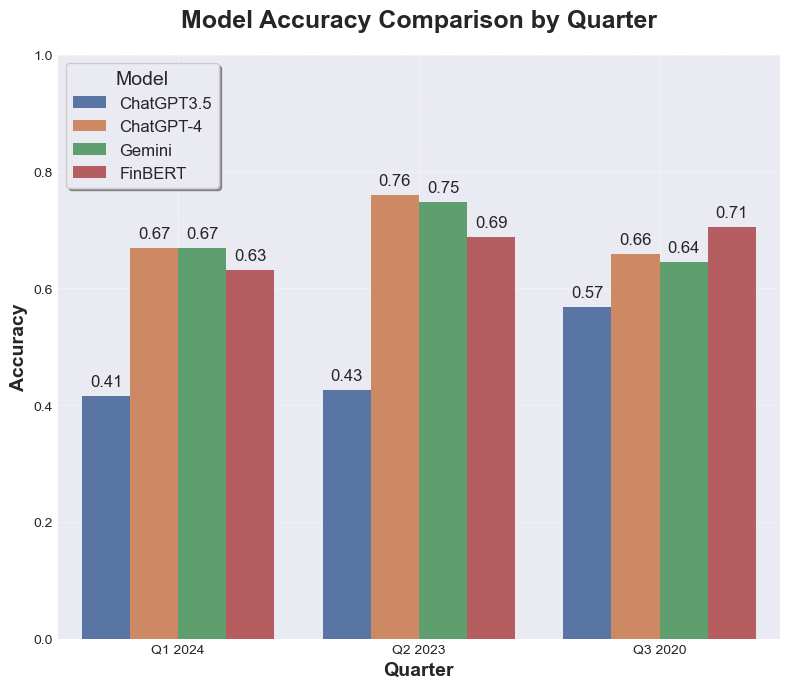

In [170]:
# Calculate accuracy for each model and quarter
# Q1 2024
accuracy_chatgpt_q1 = accuracy_score(df24['Human Evaluation'], df24['GPT 3.5'])
accuracy_chatgpt4_q1 = accuracy_score(dff24['Human Evaluation'], dff24['ChatGPT4 Evaluation'])
accuracy_gemini_q1 = accuracy_score(dfq24['Human Evaluation'], dfq24['Gemini Evaluation'])
accuracy_finbert_q1= accuracy_score(d24['Human Evaluation'], d24['FinBERT'])

# Q2 2023
accuracy_chatgpt_q2 = accuracy_score(df23['Human Evaluation'], df23['GPT 3.5'])
accuracy_chatgpt4_q2 = accuracy_score(dff23['Human Evaluation'], dff23['ChatGPT4 Evaluation'])
accuracy_gemini_q2 = accuracy_score(dfq23['Human Evaluation'], dfq23['Gemini Evaluation'])
accuracy_finbert_q2= accuracy_score(d23['Human Evaluation'], d23['FinBERT'])

# Q3 2020
accuracy_chatgpt_q3 = accuracy_score(df20['Human Evaluation'], df20['GPT 3.5'])
accuracy_chatgpt4_q3 = accuracy_score(dff20['Human Evaluation'], dff20['ChatGPT4 Evaluation'])
accuracy_gemini_q3 = accuracy_score(dfq20['Human Evaluation'], dfq20['Gemini Evaluation'])
accuracy_finbert_q3= accuracy_score(d20['Human Evaluation'], d20['FinBERT'])

# Set a modern style for the plot
plt.style.use('seaborn-darkgrid')

# Create a DataFrame to store the accuracy data
accuracy_data = {
    'Quarter': ['Q1 2024', 'Q2 2023', 'Q3 2020'],
    'ChatGPT3.5': [accuracy_chatgpt_q1, accuracy_chatgpt_q2, accuracy_chatgpt_q3],
    'ChatGPT-4': [accuracy_chatgpt4_q1, accuracy_chatgpt4_q2, accuracy_chatgpt4_q3],
    'Gemini': [accuracy_gemini_q1, accuracy_gemini_q2, accuracy_gemini_q3],
    'FinBERT': [accuracy_finbert_q1, accuracy_finbert_q2, accuracy_finbert_q3]
}

# Convert to DataFrame
accuracy_df = pd.DataFrame(accuracy_data)

# Reshape the DataFrame to make it suitable for side-by-side plotting
accuracy_df = accuracy_df.melt(id_vars='Quarter', var_name='Model', value_name='Accuracy')

# Define a color palette with distinct colors for each model
colors = ['#4c72b0', '#dd8452', '#55a868', '#c44e52']  

# Plot the accuracy comparison
plt.figure(figsize=(8, 7))
ax = sns.barplot(x='Quarter', y='Accuracy', hue='Model', data=accuracy_df, palette=colors)

# Add title and labels with enhanced font sizes and bold font
plt.title('Model Accuracy Comparison by Quarter', fontsize=18, weight='bold', pad=20)
plt.ylabel('Accuracy', fontsize=14, weight='bold')
plt.xlabel('Quarter', fontsize=14, weight='bold')
plt.ylim(0, 1)  # Ensure y-axis goes from 0 to 1 for accuracy

# Add numbers on top of each bar with larger font size and 2 decimal places
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=12, padding=5)

# Adjust the legend
ax.legend(title='Model', loc='upper left', fontsize=12, title_fontsize='14', frameon=True, shadow=True)

# Add gridlines to improve readability
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust the layout to make room for labels and title
plt.tight_layout()

# Display the plot
plt.show()

Timing , Consistency , Accuracy, Reevaluation



Analysis Insights
Overall Alignment: Review the agreement and disagreement rates. High alignment with human experts suggests ChatGPT could be a reliable tool.
Error Patterns: Use the confusion matrix and correlation metrics to identify if specific sentiment categories (positive, neutral, negative) are more prone to errors.
Consistency Over Time: Ensure that ChatGPT's performance is stable across different quarters, which is critical for a reliable replacement.
Impact of Errors: Analyze the nature of ChatGPT's mistakes. If the errors are minor and context-specific, the risk may be manageable. However, frequent errors in critical areas could pose challenges.

The analysis should focus on comparing performance across different metrics, understanding the types of errors ChatGPT makes, and evaluating the consistency of its performance over time.

 Compare and Contrast ChatGPT’s Outputs
Human vs. ChatGPT Outputs: For each selected sentence, compare ChatGPT’s output with the human expert's evaluation. Note any differences and consider the potential reasons behind these discrepancies.
Contextual Considerations: Evaluate whether ChatGPT missed any contextual cues that a human expert might have picked up on. This could include understanding the tone of the speaker or recognizing sarcasm or caution in language.

Operational Costs: Evaluate the cost-effectiveness of deploying ChatGPT in place of human analysts. Consider not only the model's licensing costs but also infrastructure, data processing, and integration costs.

limitation of LLMs should have access to specific financial data, which is often confidential would lead to higher accuracy, also another aspect of limitations would be to use more earnings calls

## Highlighting and Exporting Discrepancies Between Human Evaluation and LLM Evaluation to Excel for Qualitative Analysis

In [171]:
# Function to calculate the difference between human and LLM evaluations and save to Excel with highlighting
def process_dataframe(df, human_col, model_col, output_path, sheet_name='Full Data', threshold=1):
    # Calculate the difference between human and model evaluations if not already done
    df['Difference'] = df[human_col] - df[model_col]

    # Define a highlight function to apply formatting to discrepancies greater than threshold
    def highlight_discrepancies(excel_writer, sheet_name, df, threshold):
        workbook = excel_writer.book
        worksheet = workbook[sheet_name]
        
        # Define the fill color for highlighting
        fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")
        
        # Iterate over the rows and apply the highlight where the difference is greater than the threshold
        for row in range(2, len(df) + 2):  # Start at row 2 because Excel is 1-indexed and row 1 is the header
            difference = abs(df.at[row-2, 'Difference'])  # Adjust index for 0-based
            if difference > threshold:
                for col in range(1, len(df.columns) + 1):  # Highlight across all columns
                    cell = worksheet.cell(row=row, column=col)
                    cell.fill = fill

    # Save the DataFrame to an Excel file and apply highlighting
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        df.to_excel(writer, index=False, sheet_name=sheet_name)
        highlight_discrepancies(writer, sheet_name, df, threshold)

# List of dataframes with corresponding human, model columns, and output filenames
data_info = [
    (d24, 'Human Evaluation', 'FinBERT', 'highlighted_discrepancies_1Q24_finbert.xlsx'),
    (d23, 'Human Evaluation', 'FinBERT', 'highlighted_discrepancies_2Q23_finbert.xlsx'),
    (d20, 'Human Evaluation', 'FinBERT', 'highlighted_discrepancies_3Q20_finbert.xlsx'),
    (df24, 'Human Evaluation', 'GPT 3.5', 'highlighted_discrepancies_1Q24Chat3.xlsx'),
    (df23, 'Human Evaluation', 'GPT 3.5', 'highlighted_discrepancies_2Q23Chat3.xlsx'),
    (df20, 'Human Evaluation', 'GPT 3.5', 'highlighted_discrepancies_3Q20Chat3.xlsx'),
    (dff24, 'Human Evaluation', 'ChatGPT4 Evaluation', 'highlighted_discrepancies_1Q24Chat4.xlsx'),
    (dff23, 'Human Evaluation', 'ChatGPT4 Evaluation', 'highlighted_discrepancies_2Q23Chat4.xlsx'),
    (dff20, 'Human Evaluation', 'ChatGPT4 Evaluation', 'highlighted_discrepancies_3Q20Chat4.xlsx'),
    (dfq24, 'Human Evaluation', 'Gemini Evaluation', 'highlighted_discrepancies_1Q24Gemini.xlsx'),
    (dfq23, 'Human Evaluation', 'Gemini Evaluation', 'highlighted_discrepancies_2Q23Gemini.xlsx'),
    (dfq20, 'Human Evaluation', 'Gemini Evaluation', 'highlighted_discrepancies_3Q20Gemini.xlsx'),
]

# Process each dataframe and save the output with highlighted discrepancies
for df, human_col, model_col, output_path in data_info:
    process_dataframe(df, human_col, model_col, output_path)


## Keywoard Extraction and Sentiment Analysis  

Q3 2020

In [172]:
# Load the dataset for Q3 2020
data20 = pd.read_excel('3Q20 Earnings.xlsx')  # Q3 2020

# Combine all sentences into a single document string
document_text_20 = ' '.join(data20['Sentence'].tolist())

# Define a function to extract keywords from the entire document
def extract_keywords(document, model="gpt-3.5-turbo"):  # Use GPT-3.5 model
    prompt = f"""
    You are a financial analyst specializing in earnings calls. 
    Given the entire earnings call transcript provided below, extract the most relevant keywords that capture the main topics, important details, and key points of discussion in the document. Ensure that the keywords are 
    concise and representative of the overall content.
    
    Document:
    ```
    {document}
    ```

    Please provide the keywords as a comma-separated list.
    """

    # Send the prompt to the OpenAI API
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0.2
    )

    # Extract keywords from the response
    try:
        keywords = response.choices[0].message['content'].strip()
        return [keyword.strip() for keyword in keywords.split(',')]
    except Exception as e:
        print(f"Error extracting keywords: {e}")
        return []

# Define a function to analyze sentiment for sentences containing each keyword
def analyze_keyword_sentiment(keywords, sentences, model="gpt-3.5-turbo"):
    keyword_sentiments = []

    for keyword in keywords:
        # Extract sentences containing the keyword
        keyword_sentences = [sentence for sentence in sentences if keyword.lower() in sentence.lower()]
        if not keyword_sentences:
            continue
        
        # Join sentences for context
        keyword_context = ' '.join(keyword_sentences)

        # Create a prompt to analyze sentiment
        prompt = f"""
        You are a financial analyst reviewing an earnings call transcript. The following text contains sentences that mention the keyword '{keyword}'.
        Analyze the overall sentiment for this keyword based on these sentences. Classify the sentiment as Positive, Neutral, or Negative.

        Sentences:
        ```
        {keyword_context}
        ```

        Sentiment Analysis:
        """
        
        # Send the prompt to GPT API
        messages = [{"role": "user", "content": prompt}]
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=0.3
        )

        try:
            sentiment = response.choices[0].message['content'].strip()
            keyword_sentiments.append((keyword, sentiment))
        except Exception as e:
            print(f"Error analyzing sentiment for keyword '{keyword}': {e}")

    return keyword_sentiments

# Extract keywords from the entire document
keywords_20 = extract_keywords(document_text_20)

# Display the extracted keywords for the entire document
print("Keywords for Q3 2020:")
print(', '.join(keywords_20))

# Analyze sentiment for each extracted keyword based on their context
if keywords_20:
    sentiment_analysis_20 = analyze_keyword_sentiment(keywords_20, data20['Sentence'].tolist())
    print("\nSentiment Analysis for Each Keyword in Q3 2020:")
    for keyword, sentiment in sentiment_analysis_20:
        print(f"Keyword: {keyword}\nSentiment: {sentiment}\n")

    # Save the keywords and sentiment analysis to a text file
    with open('gpt3.5_keywords_sentiment_analysis_Q3_2020.txt', 'w') as file:
        file.write("Keywords for Q3 2020:\n")
        file.write(', '.join(keywords_20) + "\n\n")
        file.write("Sentiment Analysis for Each Keyword:\n")
        for keyword, sentiment in sentiment_analysis_20:
            file.write(f"Keyword: {keyword}\nSentiment: {sentiment}\n\n")
else:
    print("No keywords extracted for Q3 2020.")


Keywords for Q3 2020:
Exxon Mobil Corporation, NYSE:XOM, Q3 2020, Earnings Conference Call, October 30, 2020, Operator, Vice President of Investor Relations, Secretary, Stephen Littleton, Andy Swiger, Jack Williams, Upstream, Downstream, Chemical, Market Dynamics, Financial Priorities, CapEx Reduction, Renewable Diesel, Direct Air Capture Technology, Quarterly Results, Earnings Improvement, Liquids Prices, Gas Realizations, Refining Margins, Chemical Margins, Cost Reductions, Structural Efficiencies, Workforce Reduction, Divestments, Carbon Emissions, Decarbonization, Refining Footprint, Integration, Competitive Refineries, Asset Investments.

Sentiment Analysis for Each Keyword in Q3 2020:
Keyword: Exxon Mobil Corporation
Sentiment: Neutral

Keyword: NYSE:XOM
Sentiment: Neutral

Keyword: Q3 2020
Sentiment: Neutral

Keyword: Earnings Conference Call
Sentiment: Neutral

Keyword: October 30
Sentiment: Neutral

Keyword: 2020
Sentiment: Based on the sentences provided, the overall sentimen

Q2 2023

In [173]:
# Load the dataset for Q2 2023
data23 = pd.read_excel('2Q23 Earnings.xlsx')  # Q2 2023

# Combine all sentences into a single document string
document_text_23 = ' '.join(data23['Sentence'].tolist())

# Extract keywords from the entire document
keywords_23 = extract_keywords(document_text_23)

# Display the extracted keywords for the entire document
print("Keywords for Q2 2023:")
print(', '.join(keywords_23))

# Analyze sentiment for each extracted keyword based on their context
if keywords_23:
    sentiment_analysis_23 = analyze_keyword_sentiment(keywords_23, data23['Sentence'].tolist())
    print("\nSentiment Analysis for Each Keyword in Q2 2023:")
    for keyword, sentiment in sentiment_analysis_23:
        print(f"Keyword: {keyword}\nSentiment: {sentiment}\n")

    # Save the keywords and sentiment analysis to a text file
    with open('gpt3.5_keywords_sentiment_analysis_Q2_2023.txt', 'w') as file:
        file.write("Keywords for Q2 2023:\n")
        file.write(', '.join(keywords_23) + "\n\n")
        file.write("Sentiment Analysis for Each Keyword:\n")
        for keyword, sentiment in sentiment_analysis_23:
            file.write(f"Keyword: {keyword}\nSentiment: {sentiment}\n\n")
else:
    print("No keywords extracted for Q2 2023.")


Keywords for Q2 2023:
ExxonMobil, earnings call, second quarter, Darren Woods, Kathy Mikells, acquisitions, Denbury, transformation, portfolio, growth, production, Guyana, Permian, Baytown, Gulf Coast, divestments, Low Carbon Solutions, carbon capture, storage, synergies, CCS deployment, earnings power, cost savings, cash flow, operations, capex investments, shareholder value, technology, projects, trading, supply chain, business solutions, talent development, industry leader, emissions reduction, structural improvements, competitive position, value creation, opportunities, investments, returns, balance sheet, flexibility, capital deployment, advantaged projects, volume, margins, market environment, inflation, deflation, costs, production levels, downtime, energy product sales, Beaumont.

Sentiment Analysis for Each Keyword in Q2 2023:
Keyword: ExxonMobil
Sentiment: The overall sentiment for the keyword 'ExxonMobil' in the provided text is Positive. This is indicated by the mentions of

Q1 2024

In [174]:
# Load the dataset for Q1 2024
data24 = pd.read_excel('1Q24 Earnings.xlsx')  # Q1 2024

# Combine all sentences into a single document string
document_text_24 = ' '.join(data24['Sentence'].tolist())

# Extract keywords from the entire document
keywords_24 = extract_keywords(document_text_24)

# Display the extracted keywords for the entire document
print("Keywords for Q1 2024:")
print(', '.join(keywords_24))

# Analyze sentiment for each extracted keyword based on their context
if keywords_24:
    sentiment_analysis_24 = analyze_keyword_sentiment(keywords_24, data24['Sentence'].tolist())
    print("\nSentiment Analysis for Each Keyword in Q1 2024:")
    for keyword, sentiment in sentiment_analysis_24:
        print(f"Keyword: {keyword}\nSentiment: {sentiment}\n")

    # Save the keywords and sentiment analysis to a text file
    with open('gpt3.5_keywords_sentiment_analysis_Q1_2024.txt', 'w') as file:
        file.write("Keywords for Q1 2024:\n")
        file.write(', '.join(keywords_24) + "\n\n")
        file.write("Sentiment Analysis for Each Keyword:\n")
        for keyword, sentiment in sentiment_analysis_24:
            file.write(f"Keyword: {keyword}\nSentiment: {sentiment}\n\n")
else:
    print("No keywords extracted for Q1 2024.")


Keywords for Q1 2024:
ExxonMobil, earnings call, Q1 2024, Darren Woods, Kathy Mikells, cost savings, structural, projects, earnings growth, Guyana, Pioneer, balance sheet, buybacks, dividends, strategic, refineries, European footprint, LNG, gas-to-power, direct air capture, technology, competitive, cost reduction.

Sentiment Analysis for Each Keyword in Q1 2024:
Keyword: ExxonMobil
Sentiment: Based on the sentences provided, the overall sentiment for the keyword 'ExxonMobil' is Positive. The sentences mention positive aspects such as improving fundamental earnings power, making a positive difference in the world, and meeting essential energy needs.

Keyword: earnings call
Sentiment: Neutral

Keyword: Darren Woods
Sentiment: The overall sentiment for Darren Woods based on the provided sentences is Positive. Darren Woods is seen as actively participating in the discussion, providing insights, and expressing gratitude throughout the earnings call transcript.

Keyword: Kathy Mikells
Sentim